## 1. Dependencies Import

In [44]:
# Essential libraries for data handling and modeling
import math
import pandas as pd
import numpy as np

# Machine learning libraries
from catboost import CatBoostClassifier
from sklearn.metrics import precision_score, classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.inspection import permutation_importance

# Visualization libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import shap

# Optimization library
import optuna
from optuna.samplers import TPESampler

# Other libraries
from datetime import datetime
import pickle

# Project-specific modules
from config.utils import load_config
from utils.utils import (
    get_odds_for_fighter,
    add_fighter_prefix,
    get_rolling_features,
    get_stats,
    get_seconds,
    get_lan_thr_cols,
    get_fight_lasted,
    get_weight_class,
    feet_to_inches,
    swap_fighter_positions,
    plot_corr_matrix,
    plot_countplot,
    plot_lineplot,
    plot_hist,
    plot_scatterplots
)


shap.initjs()

plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

CONFIG_PATH = './config/config.yaml'
config = load_config(CONFIG_PATH)

EVENTS_COLUMNS = config.get("EVENTS_COLUMNS")
COLUMNS_TO_SPLIT = config.get("COLUMNS_TO_SPLIT")
COLUMNS_TO_RENAME = config.get("COLUMNS_TO_RENAME")
COLUMNS_TO_REMOVE = config.get("COLUMNS_TO_REMOVE")
COLUMNS_TO_SHIFT = config.get("COLUMNS_TO_SHIFT")
COLUMNS_TO_SWAP = config.get("COLUMNS_TO_SWAP")
COLUMNS_TO_GET_ROLLING_MEANS = config.get("COLUMNS_TO_GET_ROLLING_MEANS")
COLUMNS_FOR_SUBPLOTS = config.get("COLUMNS_FOR_SUBPLOTS")

## 2. Data Collection

<div style="margin-left: 2em;">
<font color='gray'>Web scrapers were written and then data was pulled. All the files are available in "web_scrapers" folder.</font>
</div>


## 3. Data Cleaning

### <div style="margin-left: 1em;">Fighter's Features Description</div>

<div style="margin-left: 3em;"><font color='gray'>These features represent individual fighter's carrier statistics taken as of February 2024. Most of them are pretty self explanatory except maybe for the "record" and "dob" which are date of birth and number of wins, losses, draws and no-contests (if value is present) respectively.</font></div>

In [45]:
fighters_df = pd.read_csv(
    './web_scrapers/fighters_stats.csv', header=0, sep=','
)
fighters_df.head()

,name,record,height,weight,reach,stance,dob
0,Tom Aaron,5-3-0,--,155 lbs.,--,NaN,"Jul 13, 1978"
1,Danny Abbadi,4-6-0,"5' 11""",155 lbs.,--,Orthodox,"Jul 03, 1983"
2,Nariman Abbasov,28-4-0,"5' 8""",155 lbs.,"66""",Orthodox,"Feb 01, 1994"
3,David Abbott,10-15-0,"6' 0""",265 lbs.,--,Switch,--
4,Hamdy Abdelwahab,5-0-0 (1 NC),"6' 2""",264 lbs.,"72""",Southpaw,"Jan 22, 1993"


In [46]:
fighters_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4113 entries, 0 to 4112
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    4113 non-null   object
 1   record  4113 non-null   object
 2   height  4113 non-null   object
 3   weight  4113 non-null   object
 4   reach   4113 non-null   object
 5   stance  3288 non-null   object
 6   dob     4113 non-null   object
dtypes: object(7)
memory usage: 225.1+ KB


In [47]:
fighters_df.describe(include='object')

,name,record,height,weight,reach,stance,dob
count,4113,4113,4113,4113,4113,3288,4113
unique,4107,1222,27,113,28,5,2845
top,Mike Davis,0-1-0,"6' 0""",155 lbs.,--,Orthodox,--
freq,2,78,437,621,1929,2526,755


In [48]:
fighters_df.loc[fighters_df.duplicated('name', keep=False)]

,name,record,height,weight,reach,stance,dob
821,Mike Davis,2-0-0,--,--,--,NaN,--
826,Mike Davis,10-2-0,"6' 0""",155 lbs.,"72""",Orthodox,"Oct 07, 1992"
1308,Joey Gomez,6-2-0,"5' 10""",135 lbs.,"73""",Orthodox,"Jul 21, 1986"
1310,Joey Gomez,7-1-0,"5' 10""",155 lbs.,"71""",Orthodox,"Aug 29, 1989"
1742,Tony Johnson,7-2-0,"6' 2""",205 lbs.,"76""",Orthodox,"May 02, 1983"
1750,Tony Johnson,11-3-0,"6' 1""",265 lbs.,--,NaN,--
2328,Michael McDonald,1-1-0,"5' 11""",205 lbs.,--,Orthodox,"Feb 06, 1965"
2330,Michael McDonald,17-4-0,"5' 9""",135 lbs.,"70""",Orthodox,"Jan 15, 1991"
3412,Jean Silva,19-12-3 (1 NC),"5' 6""",160 lbs.,--,Orthodox,"Oct 08, 1977"
3426,Bruno Silva,13-5-2 (1 NC),"5' 4""",125 lbs.,"65""",Orthodox,"Mar 16, 1990"


In [49]:
# Dropping fighters with the same name as we won't be able to 
# figure out for instance which Mike Davis fought in a fight 
fighters_df = (
    fighters_df[~fighters_df.duplicated('name', keep=False)]
        .reset_index(drop=True)
)

# Replacing "--" with NaNs
fighters_df.replace('--', np.nan, inplace=True)

# Converting "dob" column to datetime type
fighters_df.dob = fighters_df.dob.apply(
    lambda x: datetime.strptime(x, '%b %d, %Y') if pd.notnull(x) else x
)

# Converting "height" to inches
fighters_df['height'] = fighters_df['height'].apply(feet_to_inches)

# Trimming "reach" column
fighters_df['reach'] = fighters_df['reach'].apply(
    lambda x: int(x[:-1]) if pd.notnull(x) else x
)

# Dropping 'weight' column as it's the last observed weight of the fighter
# and it is not relevant for the model as it a constant feature 
# Dropping 'record' column as it's a rolling feature taken only as of Feb, 2024
# Later on we'll create rolling features for each fighter's event 
fighters_df.drop(['record', 'weight'], axis=1, inplace=True)

fighters_df.head()

,name,height,reach,stance,dob
0,Tom Aaron,NaN,NaN,NaN,1978-07-13
1,Danny Abbadi,71.0,NaN,Orthodox,1983-07-03
2,Nariman Abbasov,68.0,66.0,Orthodox,1994-02-01
3,David Abbott,72.0,NaN,Switch,NaT
4,Hamdy Abdelwahab,74.0,72.0,Southpaw,1993-01-22


### <div style="margin-left: 1em;">Fight's Additional Features Description </div>

<div style="margin-left: 3em;"><font color='gray'>These features represent individual fights's statistics along with the betting odds taken as of February 2024.</font></div>

In [50]:
fights_odds_df = pd.read_csv(
    './web_scrapers/fights_odds.csv', header=0, sep=','
)
fights_odds_df.head()

,event,date,favourite,favourite_odds,underdog,underdog_odds,result
0,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Jon Jones,1.13,Chael Sonnen,9.00,Favourite
1,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Michael Bisping,1.57,Alan Belcher,4.50,Favourite
2,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Roy Nelson,1.43,Cheick Kongo,3.20,Favourite
3,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Phil Davis,1.36,Vinny Magalhaes,3.55,Favourite
4,UFC 159 - Jones vs. Sonnen,27th Apr 2013,Jim Miller,1.40,Pat Healy,3.40,Underdog


In [51]:
fights_odds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4227 entries, 0 to 4226
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   event           4227 non-null   object 
 1   date            4227 non-null   object 
 2   favourite       4227 non-null   object 
 3   favourite_odds  4227 non-null   float64
 4   underdog        4227 non-null   object 
 5   underdog_odds   4227 non-null   float64
 6   result          4227 non-null   object 
dtypes: float64(2), object(5)
memory usage: 231.3+ KB


In [52]:
fights_odds_df.describe(include='object')

,event,date,favourite,underdog,result
count,4227,4227,4227,4227,4227
unique,346,355,1242,1402,3
top,UFC FN,19th Nov 2016,Vicente Luque,Andrei Arlovski,Favourite
freq,136,25,15,21,2712


In [53]:
fights_odds_df.describe()

,favourite_odds,underdog_odds
count,4227.00,4227.00
mean,inf,inf
std,NaN,NaN
min,1.06,1.88
25%,1.38,2.35
50%,1.56,2.80
75%,1.73,3.63
max,inf,inf


In [54]:
# Converting "date" column to datetime type
fights_odds_df.date = pd.to_datetime(
    fights_odds_df.date.replace({'(st|nd|rd|th)': ''}, regex=True), 
    format="%d %b %Y"
)

# Replacing "inf" with NaNs
fights_odds_df.underdog_odds = (
    fights_odds_df.underdog_odds.replace(np.inf, np.nan)
)
fights_odds_df.favourite_odds = (
    fights_odds_df.favourite_odds.replace(np.inf, np.nan)
)

fights_odds_df.head()

,event,date,favourite,favourite_odds,underdog,underdog_odds,result
0,UFC 159 - Jones vs. Sonnen,2013-04-27,Jon Jones,1.13,Chael Sonnen,9.00,Favourite
1,UFC 159 - Jones vs. Sonnen,2013-04-27,Michael Bisping,1.57,Alan Belcher,4.50,Favourite
2,UFC 159 - Jones vs. Sonnen,2013-04-27,Roy Nelson,1.43,Cheick Kongo,3.20,Favourite
3,UFC 159 - Jones vs. Sonnen,2013-04-27,Phil Davis,1.36,Vinny Magalhaes,3.55,Favourite
4,UFC 159 - Jones vs. Sonnen,2013-04-27,Jim Miller,1.40,Pat Healy,3.40,Underdog


### <div style="margin-left: 1em;">Fight's Base Features Description</div>

<div style="margin-left: 3em;"><font color='gray'>These features represent individual fight's statistics taken as of February 2024.
Prefixes <font color='#A9A9A9'><strong>f1_</strong></font> and <font color='#A9A9A9'><strong>f2_</strong></font> stand for the first and second fighters statistics respectively.

Some features described:
- **<font color='#A9A9A9'>fighter_1_result</font>**: The result of the fight for Fighter 1 (win, lose, draw or nc).
- **<font color='#A9A9A9'>title</font>**: Indicates the title type (e.g., championship, interim).
- **<font color='#A9A9A9'>method</font>**: The method by which the fight was won (e.g., KO, submission, decision).
- **<font color='#A9A9A9'>last_round</font>**: The round in which the fight ended (if applicable).
- **<font color='#A9A9A9'>last_round_time</font>**: The time at which the fight ended in the last round (if applicable).
- **<font color='#A9A9A9'>time_format</font>**: The format used to denote time (e.g., minutes and seconds).
- **<font color='#A9A9A9'>referee</font>**: The referee who officiated the fight.
- **<font color='#A9A9A9'>details</font>**: Additional details about the fight outcome or circumstances.
- **<font color='#A9A9A9'>total_knock_downs</font>**: The total number of knockdowns scored by a fighter.
- **<font color='#A9A9A9'>total_signif_str</font>**: The total significant strikes landed by a fighter.
- **<font color='#A9A9A9'>total_total_str</font>**: The total strikes (significant and non-significant) landed by a fighter.
- **<font color='#A9A9A9'>total_take_downs</font>**: The total takedowns executed by a fighter.
- **<font color='#A9A9A9'>total_sub_atts</font>**: The total submission attempts made by a fighter.
- **<font color='#A9A9A9'>total_rev</font>**: The total reversals executed by a fighter.
- **<font color='#A9A9A9'>total_ctrl</font>**: The total control time (time spent in dominant positions) for a fighter.
- **<font color='#A9A9A9'>total_head</font>**: The total strikes landed to the head by a fighter.
- **<font color='#A9A9A9'>total_body</font>**: The total strikes landed to the body by a fighter.
- **<font color='#A9A9A9'>total_leg</font>**: The total strikes landed to the legs by a fighter.
- **<font color='#A9A9A9'>total_distance</font>**: The total strikes landed from a distance by a fighter.
- **<font color='#A9A9A9'>total_clinch</font>**: The total strikes landed in the clinch by a fighter.
- **<font color='#A9A9A9'>total_ground</font>**: The total strikes landed on the ground by a fighter.</font></div>

In [55]:
fights_df = pd.read_csv(
    './web_scrapers/fights_stats.csv', header=0
)
column_rename = {
    "fighter_1": "f1_name",
    "fighter_2": "f2_name"
}

fights_df = fights_df.rename(columns=column_rename)
fights_df.head()

,event_name,event_location,event_datetime,f1_name,f2_name,fighter_1_result,title,method,last_round,last_round_time,time_format,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground
0,Strikeforce - Henderson vs. Babalu,"St. Louis, Missouri, USA","Dec. 04, 2010",Tom Aaron,Matt Ricehouse,L,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),NaN,Al Wichgers27 - 30.Jackson Harper28 - 29.Jerry...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Strikeforce - Heavy Artillery,"St. Louis, Missouri, USA","May. 15, 2010",Tom Aaron,Eric Steenberg,W,Catch Weight Bout,Submission,1,0:56,3 Rnd (5-5-5),Al Wichgers,Guillotine Choke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,UFC 63: Hughes vs Penn,"Anaheim, California, USA","Sep. 23, 2006",Jorge Gurgel,Danny Abbadi,W,Lightweight Bout,Decision - Split,3,5:00,3 Rnd (5-5-5),Herb Dean,Cecil Peoples29 - 28.Nelson Hamilton28 - 29.Al...,0.0,0.0,58 of 159,56 of 146,101 of 208,79 of 173,1 of 7,0 of 0,1.0,0.0,0.0,0.0,2:03,1:50,49 of 149,49 of 137,6 of 7,7 of 9,3 of 3,0 of 0,44 of 128,41 of 122,12 of 18,12 of 20,2 of 13,3 of 4
3,The Ultimate Fighter: Team Ortiz vs. Team Sham...,"Las Vegas, Nevada, USA","Jun. 24, 2006",Kalib Starnes,Danny Abbadi,W,Middleweight Bout,Submission,1,2:56,3 Rnd (5-5-5),Mario Yamasaki,Rear Naked Choke,0.0,0.0,21 of 29,3 of 9,25 of 33,6 of 12,1 of 2,0 of 0,1.0,0.0,0.0,0.0,1:41,0:00,10 of 17,2 of 8,11 of 12,1 of 1,0 of 0,0 of 0,2 of 5,1 of 5,5 of 5,2 of 4,14 of 19,0 of 0
4,DWCS 6.7,"Las Vegas, Nevada, USA","Sep. 06, 2022",Ismael Bonfim,Nariman Abbasov,W,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,Chris Flores27 - 30.Adalaide Byrd27 - 30.Mike ...,1.0,0.0,85 of 158,45 of 225,85 of 158,45 of 225,1 of 3,0 of 2,0.0,0.0,0.0,0.0,0:06,0:21,63 of 133,26 of 197,19 of 21,8 of 11,3 of 4,11 of 17,77 of 144,45 of 224,5 of 7,0 of 1,3 of 7,0 of 0


In [56]:
fights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19838 entries, 0 to 19837
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   event_name            19838 non-null  object 
 1   event_location        19838 non-null  object 
 2   event_datetime        19838 non-null  object 
 3   f1_name               19838 non-null  object 
 4   f2_name               19838 non-null  object 
 5   fighter_1_result      19838 non-null  object 
 6   title                 19838 non-null  object 
 7   method                19838 non-null  object 
 8   last_round            19838 non-null  int64  
 9   last_round_time       19838 non-null  object 
 10  time_format           19838 non-null  object 
 11  referee               19246 non-null  object 
 12  details               19044 non-null  object 
 13  f1_total_knock_downs  19178 non-null  float64
 14  f2_total_knock_downs  19178 non-null  float64
 15  f1_total_signif_str

In [57]:
fights_df.describe(include='object')

,event_name,event_location,event_datetime,f1_name,f2_name,fighter_1_result,title,method,last_round_time,time_format,referee,details,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground
count,19838,19838,19838,19838,19838,19838,19838,19838,19838,19838,19246,19044,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178,19178
unique,1122,214,1079,2422,3310,4,158,11,438,36,276,4117,4582,4393,5856,5422,183,182,790,663,3863,3634,727,684,502,498,3640,3656,615,569,895,615
top,UFC 2: No Way Out,"Las Vegas, Nevada, USA","Nov. 19, 2016",Mauricio Rua,Jeremy Stephens,W,Lightweight Bout,Decision - Unanimous,5:00,3 Rnd (5-5-5),Herb Dean,Punch to Head At Distance,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,--,--,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0
freq,30,6038,50,74,42,13678,3198,6528,8520,16050,2562,1556,120,246,82,158,6194,7342,3170,3170,224,450,2366,2944,4150,4298,406,426,4792,4988,6142,8802


In [58]:
fights_df.describe()

,last_round,f1_total_knock_downs,f2_total_knock_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev
count,19838.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000,19178.000000
mean,2.230971,0.258734,0.161539,0.511628,0.334029,0.145166,0.144958
std,1.018746,0.530361,0.431678,0.969577,0.778358,0.437575,0.444267
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,6.000000,5.000000,4.000000,11.000000,9.000000,6.000000,6.000000


In [59]:
fights_df.duplicated().sum()

9919

In [60]:
# Dropping duplicates
fights_df = fights_df[~fights_df.duplicated()] \
    .reset_index() \
    .drop('index', axis=1)

# Replacing "--" with NaNs
fights_df.replace('--', np.nan, inplace=True)

# Converting "event_datetime" column to datetime type
fights_df.event_datetime = fights_df.event_datetime.apply(
    lambda x: datetime.strptime(x, '%b. %d, %Y')
)

# Transferring odds to the main dataframe

for index, row in fights_df.iterrows():

    for num, col in enumerate(['f1_name', 'f2_name']):

        odds = get_odds_for_fighter(fights_odds_df, row, col)
        fighter = col.split('_')[0]
        fights_df.at[index, f'{fighter}_odds'] = odds

del fights_odds_df
fights_df.sample(5)

,event_name,event_location,event_datetime,f1_name,f2_name,fighter_1_result,title,method,last_round,last_round_time,time_format,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,f1_odds,f2_odds
3076,UFC 138: Leben vs Munoz,"Birmingham, England, United Kingdom",2011-11-05,Chris Cope,Che Mills,L,Welterweight Bout,KO/TKO,1,0:40,3 Rnd (5-5-5),Marc Goddard,Knee to Head In Clinch,0.0,2.0,1 of 10,11 of 16,1 of 10,11 of 16,0 of 1,0 of 0,0.0,0.0,0.0,0.0,0:00,0:07,0 of 7,9 of 14,0 of 0,0 of 0,1 of 3,2 of 2,1 of 10,6 of 7,0 of 0,2 of 2,0 of 0,3 of 7,NaN,NaN
2234,UFC 258: Usman vs. Burns,"Las Vegas, Nevada, USA",2021-02-13,Kamaru Usman,Gilbert Burns,W,UFC Welterweight Title Bout,KO/TKO,3,0:34,5 Rnd (5-5-5-5-5),Herb Dean,Punches to Head On Ground,2.0,0.0,83 of 136,45 of 108,93 of 149,55 of 124,0 of 0,0 of 3,0.0,0.0,0.0,0.0,2:05,0:00,56 of 105,18 of 75,11 of 15,13 of 14,16 of 16,14 of 19,54 of 100,44 of 104,3 of 4,1 of 4,26 of 32,0 of 0,NaN,NaN
2715,UFC Fight Night: Covington vs. Woodley,"Las Vegas, Nevada, USA",2020-09-19,Donald Cerrone,Niko Price,NC,Welterweight Bout,Overturned,3,5:00,3 Rnd (5-5-5),Jason Herzog,Failed Drug Test by PriceEric Colon27 - 29.Chr...,0.0,0.0,113 of 230,150 of 312,113 of 230,167 of 330,0 of 5,0 of 1,0.0,0.0,0.0,0.0,0:50,0:47,69 of 181,80 of 225,38 of 43,30 of 42,6 of 6,40 of 45,101 of 216,129 of 284,11 of 13,18 of 24,1 of 1,3 of 4,2.32,1.74
2079,The Ultimate Fighter: Team Nogueira vs. Team M...,"Las Vegas, Nevada, USA",2008-12-13,Junie Browning,David Kaplan,W,Lightweight Bout,Submission,2,1:32,3 Rnd (5-5-5),Steve Mazzagatti,Armbar From Side Control,0.0,0.0,31 of 63,12 of 29,38 of 71,14 of 32,2 of 2,2 of 2,2.0,1.0,1.0,1.0,3:06,1:00,21 of 50,5 of 17,5 of 6,3 of 4,5 of 7,4 of 8,25 of 48,8 of 22,3 of 7,4 of 7,3 of 8,0 of 0,NaN,NaN
8234,UFC 169: Barao vs Faber 2,"Newark, New Jersey, USA",2014-02-01,Frank Mir,Alistair Overeem,L,Heavyweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Dan Miragliotta,Michelle Agustin27 - 30.Tony Tamburrino27 - 30...,0.0,1.0,3 of 23,62 of 74,5 of 26,139 of 157,1 of 3,0 of 0,1.0,0.0,0.0,0.0,0:29,8:38,0 of 17,40 of 52,1 of 3,19 of 19,2 of 3,3 of 3,3 of 23,14 of 20,0 of 0,6 of 6,0 of 0,42 of 48,4.75,1.26


In [61]:
# Merging dataframes to retrieve fighter's individual static information 
# such as height, reach, etc
fights_df = pd.merge(
    fights_df, 
    fighters_df.add_prefix('f1_'), 
    how='left', 
    on='f1_name'
)
df = pd.merge(
    fights_df, 
    fighters_df.add_prefix('f2_'), 
    how='left', 
    on='f2_name'
)

del fights_df
df.head()

,event_name,event_location,event_datetime,f1_name,f2_name,fighter_1_result,title,method,last_round,last_round_time,time_format,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,f1_odds,f2_odds,f1_height,f1_reach,f1_stance,f1_dob,f2_height,f2_reach,f2_stance,f2_dob
0,Strikeforce - Henderson vs. Babalu,"St. Louis, Missouri, USA",2010-12-04,Tom Aaron,Matt Ricehouse,L,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),NaN,Al Wichgers27 - 30.Jackson Harper28 - 29.Jerry...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978-07-13,NaN,NaN,NaN,1987-03-11
1,Strikeforce - Heavy Artillery,"St. Louis, Missouri, USA",2010-05-15,Tom Aaron,Eric Steenberg,W,Catch Weight Bout,Submission,1,0:56,3 Rnd (5-5-5),Al Wichgers,Guillotine Choke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978-07-13,NaN,NaN,NaN,1983-06-22
2,UFC 63: Hughes vs Penn,"Anaheim, California, USA",2006-09-23,Jorge Gurgel,Danny Abbadi,W,Lightweight Bout,Decision - Split,3,5:00,3 Rnd (5-5-5),Herb Dean,Cecil Peoples29 - 28.Nelson Hamilton28 - 29.Al...,0.0,0.0,58 of 159,56 of 146,101 of 208,79 of 173,1 of 7,0 of 0,1.0,0.0,0.0,0.0,2:03,1:50,49 of 149,49 of 137,6 of 7,7 of 9,3 of 3,0 of 0,44 of 128,41 of 122,12 of 18,12 of 20,2 of 13,3 of 4,NaN,NaN,67.0,69.0,Orthodox,1977-01-25,71.0,NaN,Orthodox,1983-07-03
3,The Ultimate Fighter: Team Ortiz vs. Team Sham...,"Las Vegas, Nevada, USA",2006-06-24,Kalib Starnes,Danny Abbadi,W,Middleweight Bout,Submission,1,2:56,3 Rnd (5-5-5),Mario Yamasaki,Rear Naked Choke,0.0,0.0,21 of 29,3 of 9,25 of 33,6 of 12,1 of 2,0 of 0,1.0,0.0,0.0,0.0,1:41,0:00,10 of 17,2 of 8,11 of 12,1 of 1,0 of 0,0 of 0,2 of 5,1 of 5,5 of 5,2 of 4,14 of 19,0 of 0,NaN,NaN,75.0,74.0,Orthodox,1975-01-06,71.0,NaN,Orthodox,1983-07-03
4,DWCS 6.7,"Las Vegas, Nevada, USA",2022-09-06,Ismael Bonfim,Nariman Abbasov,W,Lightweight Bout,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,Chris Flores27 - 30.Adalaide Byrd27 - 30.Mike ...,1.0,0.0,85 of 158,45 of 225,85 of 158,45 of 225,1 of 3,0 of 2,0.0,0.0,0.0,0.0,0:06,0:21,63 of 133,26 of 197,19 of 21,8 of 11,3 of 4,11 of 17,77 of 144,45 of 224,5 of 7,0 of 1,3 of 7,0 of 0,NaN,NaN,68.0,71.0,Orthodox,1995-12-28,68.0,66.0,Orthodox,1994-02-01


In [62]:
# Extracting event country
df['event_country'] = (
    df.event_location.str.split(',').str.get(-1).fillna(df.event_location)
)
df = df.drop('event_location', axis=1)

# Transforming event target
df.rename(
    columns={'fighter_1_result':'target', 'event_datetime':'event_date'},
    inplace=True
)

# Creating column indicating if the fight is for the interim's belt
df['is_interim_fight'] = df.apply(
    lambda entry: 1 if 'interim' in entry.title.lower() else 0,
    axis = 1
)

# Creating column indicating if the fight is for the champion's belt
df['is_title_fight'] = df.apply(
    lambda entry: 
        1 if ('title' in entry.title.lower()) &
        (entry.is_interim_fight != 1)
        else 0,
    axis = 1
)

# Creating column indicating if the fight is in women league
df['is_women_fight'] = df.apply(
    lambda entry: 1 if 'women' in entry.title.lower() else 0,
    axis = 1
)
  
# Getting weight class
df['weight_class'] = df['title'].apply(
    lambda title: get_weight_class(title)
)

# Dropping 'title' and 'event_name' columns
df = df.drop(["title","event_name"], axis=1)

# Mapping target
df.target = df.target.map({'W':'F1', 'L':'F2', 'D':'Draw', 'NC':'NC'})

df.head()

,event_date,f1_name,f2_name,target,method,last_round,last_round_time,time_format,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,f1_odds,f2_odds,f1_height,f1_reach,f1_stance,f1_dob,f2_height,f2_reach,f2_stance,f2_dob,event_country,is_interim_fight,is_title_fight,is_women_fight,weight_class
0,2010-12-04,Tom Aaron,Matt Ricehouse,F2,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),NaN,Al Wichgers27 - 30.Jackson Harper28 - 29.Jerry...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978-07-13,NaN,NaN,NaN,1987-03-11,USA,0,0,0,lightweight
1,2010-05-15,Tom Aaron,Eric Steenberg,F1,Submission,1,0:56,3 Rnd (5-5-5),Al Wichgers,Guillotine Choke,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978-07-13,NaN,NaN,NaN,1983-06-22,USA,0,0,0,catch weight
2,2006-09-23,Jorge Gurgel,Danny Abbadi,F1,Decision - Split,3,5:00,3 Rnd (5-5-5),Herb Dean,Cecil Peoples29 - 28.Nelson Hamilton28 - 29.Al...,0.0,0.0,58 of 159,56 of 146,101 of 208,79 of 173,1 of 7,0 of 0,1.0,0.0,0.0,0.0,2:03,1:50,49 of 149,49 of 137,6 of 7,7 of 9,3 of 3,0 of 0,44 of 128,41 of 122,12 of 18,12 of 20,2 of 13,3 of 4,NaN,NaN,67.0,69.0,Orthodox,1977-01-25,71.0,NaN,Orthodox,1983-07-03,USA,0,0,0,lightweight
3,2006-06-24,Kalib Starnes,Danny Abbadi,F1,Submission,1,2:56,3 Rnd (5-5-5),Mario Yamasaki,Rear Naked Choke,0.0,0.0,21 of 29,3 of 9,25 of 33,6 of 12,1 of 2,0 of 0,1.0,0.0,0.0,0.0,1:41,0:00,10 of 17,2 of 8,11 of 12,1 of 1,0 of 0,0 of 0,2 of 5,1 of 5,5 of 5,2 of 4,14 of 19,0 of 0,NaN,NaN,75.0,74.0,Orthodox,1975-01-06,71.0,NaN,Orthodox,1983-07-03,USA,0,0,0,middleweight
4,2022-09-06,Ismael Bonfim,Nariman Abbasov,F1,Decision - Unanimous,3,5:00,3 Rnd (5-5-5),Herb Dean,Chris Flores27 - 30.Adalaide Byrd27 - 30.Mike ...,1.0,0.0,85 of 158,45 of 225,85 of 158,45 of 225,1 of 3,0 of 2,0.0,0.0,0.0,0.0,0:06,0:21,63 of 133,26 of 197,19 of 21,8 of 11,3 of 4,11 of 17,77 of 144,45 of 224,5 of 7,0 of 1,3 of 7,0 of 0,NaN,NaN,68.0,71.0,Orthodox,1995-12-28,68.0,66.0,Orthodox,1994-02-01,USA,0,0,0,lightweight


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9919 entries, 0 to 9918
Data columns (total 51 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   event_date            9919 non-null   datetime64[ns]
 1   f1_name               9919 non-null   object        
 2   f2_name               9919 non-null   object        
 3   target                9919 non-null   object        
 4   method                9919 non-null   object        
 5   last_round            9919 non-null   int64         
 6   last_round_time       9919 non-null   object        
 7   time_format           9919 non-null   object        
 8   referee               9623 non-null   object        
 9   details               9522 non-null   object        
 10  f1_total_knock_downs  9589 non-null   float64       
 11  f2_total_knock_downs  9589 non-null   float64       
 12  f1_total_signif_str   9589 non-null   object        
 13  f2_total_signif_st

In [64]:
sorted(df.time_format.unique().tolist())

['1 Rnd (10)',
 '1 Rnd (12)',
 '1 Rnd (15)',
 '1 Rnd (18)',
 '1 Rnd (20)',
 '1 Rnd (30)',
 '1 Rnd + 2OT (15-3-3)',
 '1 Rnd + 2OT (24-3-3)',
 '1 Rnd + OT (12-3)',
 '1 Rnd + OT (15-10)',
 '1 Rnd + OT (15-3)',
 '1 Rnd + OT (27-3)',
 '1 Rnd + OT (30-3)',
 '1 Rnd + OT (30-5)',
 '1 Rnd + OT (31-5)',
 '2 Rnd (10-10)',
 '2 Rnd (10-5)',
 '2 Rnd (3-3)',
 '2 Rnd (5-5)',
 '3 Rnd (10-10-10)',
 '3 Rnd (10-10-5)',
 '3 Rnd (10-5-5)',
 '3 Rnd (2-2-2)',
 '3 Rnd (3-3-3)',
 '3 Rnd (4-4-4)',
 '3 Rnd (5-5-5)',
 '3 Rnd (8-8-8)',
 '3 Rnd + OT (5-5-5-5)',
 '4 Rnd (10-10-10-10)',
 '5 Rnd (3-3-3-3-3)',
 '5 Rnd (4-4-4-4-4)',
 '5 Rnd (5-5-5-5-5)',
 'No Time Limit',
 'Unlimited Rnd  (15)',
 'Unlimited Rnd (10)',
 'Unlimited Rnd (20)']

In [65]:
# Getting how many seconds the fight lasted
df['fight_lasted'] = df.apply(get_fight_lasted, axis=1)

# Dropping 'last_round_time', 'time_format' and 'last_round' columns
df = df.drop(["last_round_time", "time_format", "last_round"], axis=1)

# Sorting values by 'event_date' column
df.sort_values('event_date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,event_date,f1_name,f2_name,target,method,referee,details,f1_total_knock_downs,f2_total_knock_downs,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,f1_odds,f2_odds,f1_height,f1_reach,f1_stance,f1_dob,f2_height,f2_reach,f2_stance,f2_dob,event_country,is_interim_fight,is_title_fight,is_women_fight,weight_class,fight_lasted
0,1993-11-12,Gerard Gordeau,Kevin Rosier,F1,KO/TKO,Joao Alberto Barreto,to \n Corner Stoppage,1.0,0.0,11 of 17,0 of 3,11 of 17,0 of 3,0 of 0,0 of 0,0.0,0.0,0.0,0.0,NaN,NaN,7 of 13,0 of 1,1 of 1,0 of 1,3 of 3,0 of 1,5 of 8,0 of 3,0 of 0,0 of 0,6 of 9,0 of 0,NaN,NaN,77.0,NaN,Orthodox,1959-03-30,76.0,NaN,Orthodox,NaT,USA,0,0,0,open weight,59.0
1,1993-11-12,Jason DeLucia,Trent Jenkins,F1,Submission,Joao Alberto Barreto,Rear Naked Choke,0.0,0.0,3 of 9,1 of 7,3 of 9,1 of 7,1 of 2,0 of 0,1.0,0.0,0.0,0.0,NaN,NaN,3 of 7,0 of 5,0 of 1,0 of 1,0 of 1,1 of 1,3 of 9,1 of 7,0 of 0,0 of 0,0 of 0,0 of 0,NaN,NaN,71.0,NaN,Southpaw,1969-07-24,74.0,NaN,NaN,NaT,USA,0,0,0,open weight,52.0
2,1993-11-12,Royce Gracie,Gerard Gordeau,F1,Submission,Joao Alberto Barreto,Rear Naked Choke,0.0,0.0,1 of 2,0 of 0,3 of 4,0 of 0,1 of 3,0 of 0,1.0,0.0,0.0,0.0,NaN,NaN,1 of 1,0 of 0,0 of 0,0 of 0,0 of 1,0 of 0,0 of 1,0 of 0,0 of 0,0 of 0,1 of 1,0 of 0,NaN,NaN,73.0,NaN,Southpaw,1966-12-12,77.0,NaN,Orthodox,1959-03-30,USA,0,1,0,unknown weight,104.0
3,1993-11-12,Ken Shamrock,Patrick Smith,F1,Submission,Joao Alberto Barreto,Heel Hook From Guard,0.0,0.0,1 of 1,4 of 8,4 of 4,16 of 20,1 of 2,0 of 0,2.0,0.0,0.0,0.0,NaN,NaN,1 of 1,1 of 4,0 of 0,1 of 1,0 of 0,2 of 3,0 of 0,1 of 1,0 of 0,1 of 1,1 of 1,2 of 6,NaN,NaN,73.0,72.0,Orthodox,1964-02-11,74.0,NaN,Orthodox,1963-08-28,USA,0,0,0,open weight,109.0
4,1993-11-12,Royce Gracie,Art Jimmerson,F1,Submission,Joao Alberto Barreto,Other \n Position - Mount,0.0,0.0,0 of 3,0 of 0,4 of 7,0 of 0,1 of 1,0 of 0,0.0,0.0,0.0,0.0,NaN,NaN,0 of 1,0 of 0,0 of 0,0 of 0,0 of 2,0 of 0,0 of 3,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,NaN,NaN,73.0,NaN,Southpaw,1966-12-12,73.0,NaN,Orthodox,1963-08-04,USA,0,0,0,open weight,138.0


In [66]:
df.describe()

,event_date,f1_total_knock_downs,f2_total_knock_downs,f1_total_sub_atts,f2_total_sub_atts,f1_total_rev,f2_total_rev,f1_odds,f2_odds,f1_height,f1_reach,f1_dob,f2_height,f2_reach,f2_dob,is_interim_fight,is_title_fight,is_women_fight,fight_lasted
count,9919,9589.000000,9589.000000,9589.000000,9589.000000,9589.000000,9589.000000,4000.000000,3999.000000,9822.000000,8585.000000,9641,9728.000000,7551.000000,9294,9919.000000,9919.000000,9919.000000,9919.000000
mean,2014-01-30 18:31:45.434015488,0.258734,0.161539,0.511628,0.334029,0.145166,0.144958,2.017692,2.759922,70.379963,72.179150,1984-04-25 05:03:39.188880832,70.348273,71.940405,1984-10-02 11:12:53.918657216,0.003327,0.052626,0.081460,607.973788
min,1993-11-12 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.060000,1.110000,60.000000,58.000000,1958-06-08 00:00:00,60.000000,58.000000,1943-01-25 00:00:00,0.000000,0.000000,0.000000,2.000000
25%,2009-05-26 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.430000,1.730000,68.000000,70.000000,1979-09-25 00:00:00,68.000000,69.000000,1980-03-01 00:00:00,0.000000,0.000000,0.000000,245.000000
50%,2014-09-27 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.710000,2.360000,71.000000,72.000000,1984-05-22 00:00:00,70.000000,72.000000,1985-04-16 00:00:00,0.000000,0.000000,0.000000,683.000000
75%,2019-08-13 00:00:00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.350000,3.250000,73.000000,75.000000,1989-02-11 00:00:00,73.000000,75.000000,1989-12-26 00:00:00,0.000000,0.000000,0.000000,900.000000
max,2024-01-20 00:00:00,5.000000,4.000000,11.000000,9.000000,6.000000,6.000000,8.750000,14.050000,89.000000,84.000000,2004-10-08 00:00:00,89.000000,84.000000,2002-09-30 00:00:00,1.000000,1.000000,1.000000,3060.000000
std,NaN,0.530375,0.431689,0.969602,0.778378,0.437586,0.444278,0.888780,1.507476,3.484675,4.218801,NaN,3.497507,4.194844,NaN,0.057587,0.223298,0.273554,378.335769


In [67]:
df.describe(include='object')

,f1_name,f2_name,target,method,referee,details,f1_total_signif_str,f2_total_signif_str,f1_total_total_str,f2_total_total_str,f1_total_take_downs,f2_total_take_downs,f1_total_ctrl,f2_total_ctrl,f1_total_head,f2_total_head,f1_total_body,f2_total_body,f1_total_leg,f2_total_leg,f1_total_distance,f2_total_distance,f1_total_clinch,f2_total_clinch,f1_total_ground,f2_total_ground,f1_stance,f2_stance,event_country,weight_class
count,9919,9919,9919,9919,9623,9522,9589,9589,9589,9589,9589,9589,8004,8004,9589,9589,9589,9589,9589,9589,9589,9589,9589,9589,9589,9589,9683,9488,9919,9919
unique,2422,3310,4,11,276,4117,4582,4393,5856,5422,183,182,789,662,3863,3634,727,684,502,498,3640,3656,615,569,895,615,5,5,32,12
top,Mauricio Rua,Jeremy Stephens,F1,Decision - Unanimous,Herb Dean,Punch to Head At Distance,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0:00,0:00,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,0 of 0,Orthodox,Orthodox,USA,heavyweight
freq,37,21,6839,3264,1281,778,60,123,41,79,3097,3671,1001,1520,112,225,1183,1472,2075,2149,203,213,2396,2494,3071,4401,7271,7182,6669,1861


In [68]:
# Swapping fighters columns to even out target values counts
df = swap_fighter_positions(df,COLUMNS_TO_SWAP)

# Renaming columns for better readability
for fighter in ['f1', 'f2']:
    for col in df.columns:
        for key,value in COLUMNS_TO_RENAME.items():
            if col == f"{fighter}_{key}":
               new_name = f"{fighter}_{value}"
               df.rename(columns={col: new_name}, inplace=True)
               
# Parsing each proportion column into lan and thr columns
lan_thr_df = get_lan_thr_cols(df, COLUMNS_TO_SPLIT)

# Converting control time into seconds
df['f1_ctrl'] = df['f1_ctrl'].apply(get_seconds)
df['f2_ctrl'] = df['f2_ctrl'].apply(get_seconds)

df = df.drop(columns=COLUMNS_TO_SPLIT)
df = pd.concat([df, lan_thr_df], axis=1)

# Adding fight_id column as some fighters fought twice on the same date
df = df.reset_index().rename(columns={'index':'fight_id'})

# Filling missing categorical values with 'Other'
df[['f2_stance', 'f1_stance']] = df[['f2_stance', 'f1_stance']].fillna('Other')

df.head()

,fight_id,event_date,f1_name,f2_name,target,method,referee,details,f1_knock_downs,f2_knock_downs,f1_sub_atts,f2_sub_atts,f1_rev,f2_rev,f1_ctrl,f2_ctrl,f1_odds,f2_odds,f1_height,f1_reach,f1_stance,f1_dob,f2_height,f2_reach,f2_stance,f2_dob,event_country,is_interim_fight,is_title_fight,is_women_fight,weight_class,fight_lasted,f1_take_downs_thr,f2_take_downs_thr,f1_tot_str_thr,f2_tot_str_thr,f1_sig_str_thr,f2_sig_str_thr,f1_head_str_thr,f2_head_str_thr,f1_body_str_thr,f2_body_str_thr,f1_leg_str_thr,f2_leg_str_thr,f1_dist_str_thr,f2_dist_str_thr,f1_clin_str_thr,f2_clin_str_thr,f1_ground_str_thr,f2_ground_str_thr,f1_take_downs_lan,f2_take_downs_lan,f1_tot_str_lan,f2_tot_str_lan,f1_sig_str_lan,f2_sig_str_lan,f1_head_str_lan,f2_head_str_lan,f1_body_str_lan,f2_body_str_lan,f1_leg_str_lan,f2_leg_str_lan,f1_dist_str_lan,f2_dist_str_lan,f1_clin_str_lan,f2_clin_str_lan,f1_ground_str_lan,f2_ground_str_lan
0,0,1993-11-12 00:00:00,Gerard Gordeau,Kevin Rosier,F1,KO/TKO,Joao Alberto Barreto,to \n Corner Stoppage,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,77.0,NaN,Orthodox,1959-03-30 00:00:00,76.0,NaN,Orthodox,NaT,USA,0,0,0,open weight,59.0,0,0,17,3,17,3,13,1,1,1,3,1,8,3,0,0,9,0,0,0,11,0,11,0,7,0,1,0,3,0,5,0,0,0,6,0
1,1,1993-11-12 00:00:00,Trent Jenkins,Jason DeLucia,F2,Submission,Joao Alberto Barreto,Rear Naked Choke,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,74.0,NaN,Other,NaT,71.0,NaN,Southpaw,1969-07-24 00:00:00,USA,0,0,0,open weight,52.0,0,2,7,9,7,9,5,7,1,1,1,1,7,9,0,0,0,0,0,1,1,3,1,3,0,3,0,0,1,0,1,3,0,0,0,0
2,2,1993-11-12 00:00:00,Royce Gracie,Gerard Gordeau,F1,Submission,Joao Alberto Barreto,Rear Naked Choke,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,73.0,NaN,Southpaw,1966-12-12 00:00:00,77.0,NaN,Orthodox,1959-03-30 00:00:00,USA,0,1,0,unknown weight,104.0,3,0,4,0,2,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,3,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
3,3,1993-11-12 00:00:00,Patrick Smith,Ken Shamrock,F2,Submission,Joao Alberto Barreto,Heel Hook From Guard,0.0,0.0,0.0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,74.0,NaN,Orthodox,1963-08-28 00:00:00,73.0,72.0,Orthodox,1964-02-11 00:00:00,USA,0,0,0,open weight,109.0,0,2,20,4,8,1,4,1,1,0,3,0,1,0,1,0,6,1,0,1,16,4,4,1,1,1,1,0,2,0,1,0,1,0,2,1
4,4,1993-11-12 00:00:00,Royce Gracie,Art Jimmerson,F1,Submission,Joao Alberto Barreto,Other \n Position - Mount,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,73.0,NaN,Southpaw,1966-12-12 00:00:00,73.0,NaN,Orthodox,1963-08-04 00:00:00,USA,0,0,0,open weight,138.0,1,0,7,0,3,0,1,0,0,0,2,0,3,0,0,0,0,0,1,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [69]:
# Creating events_df table for feature creation
events_df = df.loc[:,EVENTS_COLUMNS]
events_df.head()

,fight_id,event_date,event_country,is_interim_fight,is_title_fight,is_women_fight,weight_class,fight_lasted,method,referee,details,f1_name,f2_name,target
0,0,1993-11-12 00:00:00,USA,0,0,0,open weight,59.0,KO/TKO,Joao Alberto Barreto,to \n Corner Stoppage,Gerard Gordeau,Kevin Rosier,F1
1,1,1993-11-12 00:00:00,USA,0,0,0,open weight,52.0,Submission,Joao Alberto Barreto,Rear Naked Choke,Trent Jenkins,Jason DeLucia,F2
2,2,1993-11-12 00:00:00,USA,0,1,0,unknown weight,104.0,Submission,Joao Alberto Barreto,Rear Naked Choke,Royce Gracie,Gerard Gordeau,F1
3,3,1993-11-12 00:00:00,USA,0,0,0,open weight,109.0,Submission,Joao Alberto Barreto,Heel Hook From Guard,Patrick Smith,Ken Shamrock,F2
4,4,1993-11-12 00:00:00,USA,0,0,0,open weight,138.0,Submission,Joao Alberto Barreto,Other \n Position - Mount,Royce Gracie,Art Jimmerson,F1


In [70]:
# Creating fighters_df table for feature creation
fighters = list()

for i, fighter in enumerate(['f1', 'f2']):
    fighter_columns = (
        load_config(CONFIG_PATH).get(f"FIGHTER_{i+1}_COLUMNS")
    )
    target_mapper = {
        f'F{i+1}': 'W', 
        f'F{2-i}': 'L',
        'Draw': 'Draw', 
        'NC': 'NC'
    }
    columns = (
        ["fight_id", "event_date", "fight_lasted"] + 
        fighter_columns
    )
    fighter_df = df.loc[:,columns]
    columns_mapper =  {
        col:col.split('_',1)[1] if col.startswith(fighter) else col 
        for col in columns
    }
    fighter_df.rename(columns=columns_mapper, inplace=True)
    fighter_df["target"] = df["target"].map(target_mapper)

    fighters.append(fighter_df)

fighters_df = pd.concat([fighters[0], fighters[1]],axis=0)

del fighters

fighters_df = (
    fighters_df.sort_values('fight_id', ascending=True).reset_index(drop=True)
)
fighters_df.head()

,fight_id,event_date,fight_lasted,name,dob,odds,height,stance,reach,knock_downs,sub_atts,rev,ctrl,tot_str_lan,tot_str_thr,sig_str_lan,sig_str_thr,take_downs_lan,take_downs_thr,head_str_lan,head_str_thr,body_str_lan,body_str_thr,leg_str_lan,leg_str_thr,dist_str_lan,dist_str_thr,clin_str_lan,clin_str_thr,ground_str_lan,ground_str_thr,target
0,0,1993-11-12 00:00:00,59.0,Gerard Gordeau,1959-03-30 00:00:00,NaN,77.0,Orthodox,NaN,1.0,0.0,0.0,NaN,11,17,11,17,0,0,7,13,1,1,3,3,5,8,0,0,6,9,W
1,0,1993-11-12 00:00:00,59.0,Kevin Rosier,NaT,NaN,76.0,Orthodox,NaN,0.0,0.0,0.0,NaN,0,3,0,3,0,0,0,1,0,1,0,1,0,3,0,0,0,0,L
2,1,1993-11-12 00:00:00,52.0,Jason DeLucia,1969-07-24 00:00:00,NaN,71.0,Southpaw,NaN,0.0,1.0,0.0,NaN,3,9,3,9,1,2,3,7,0,1,0,1,3,9,0,0,0,0,W
3,1,1993-11-12 00:00:00,52.0,Trent Jenkins,NaT,NaN,74.0,Other,NaN,0.0,0.0,0.0,NaN,1,7,1,7,0,0,0,5,0,1,1,1,1,7,0,0,0,0,L
4,2,1993-11-12 00:00:00,104.0,Royce Gracie,1966-12-12 00:00:00,NaN,73.0,Southpaw,NaN,0.0,1.0,0.0,NaN,3,4,1,2,1,3,1,1,0,0,0,1,0,1,0,0,1,1,W


In [71]:
df.to_parquet('./processed_data/df.parquet')
fighters_df.to_parquet('./processed_data/fighters_df.parquet')
events_df.to_parquet('./processed_data/events_df.parquet')

## 4. Data Visualization

In [72]:
df = pd.read_parquet('./processed_data/df.parquet')
fighters_df = pd.read_parquet('./processed_data/fighters_df.parquet')
events_df = pd.read_parquet('./processed_data/events_df.parquet')

### <div style="margin-left: 1em;">Correlation Analysis</div>

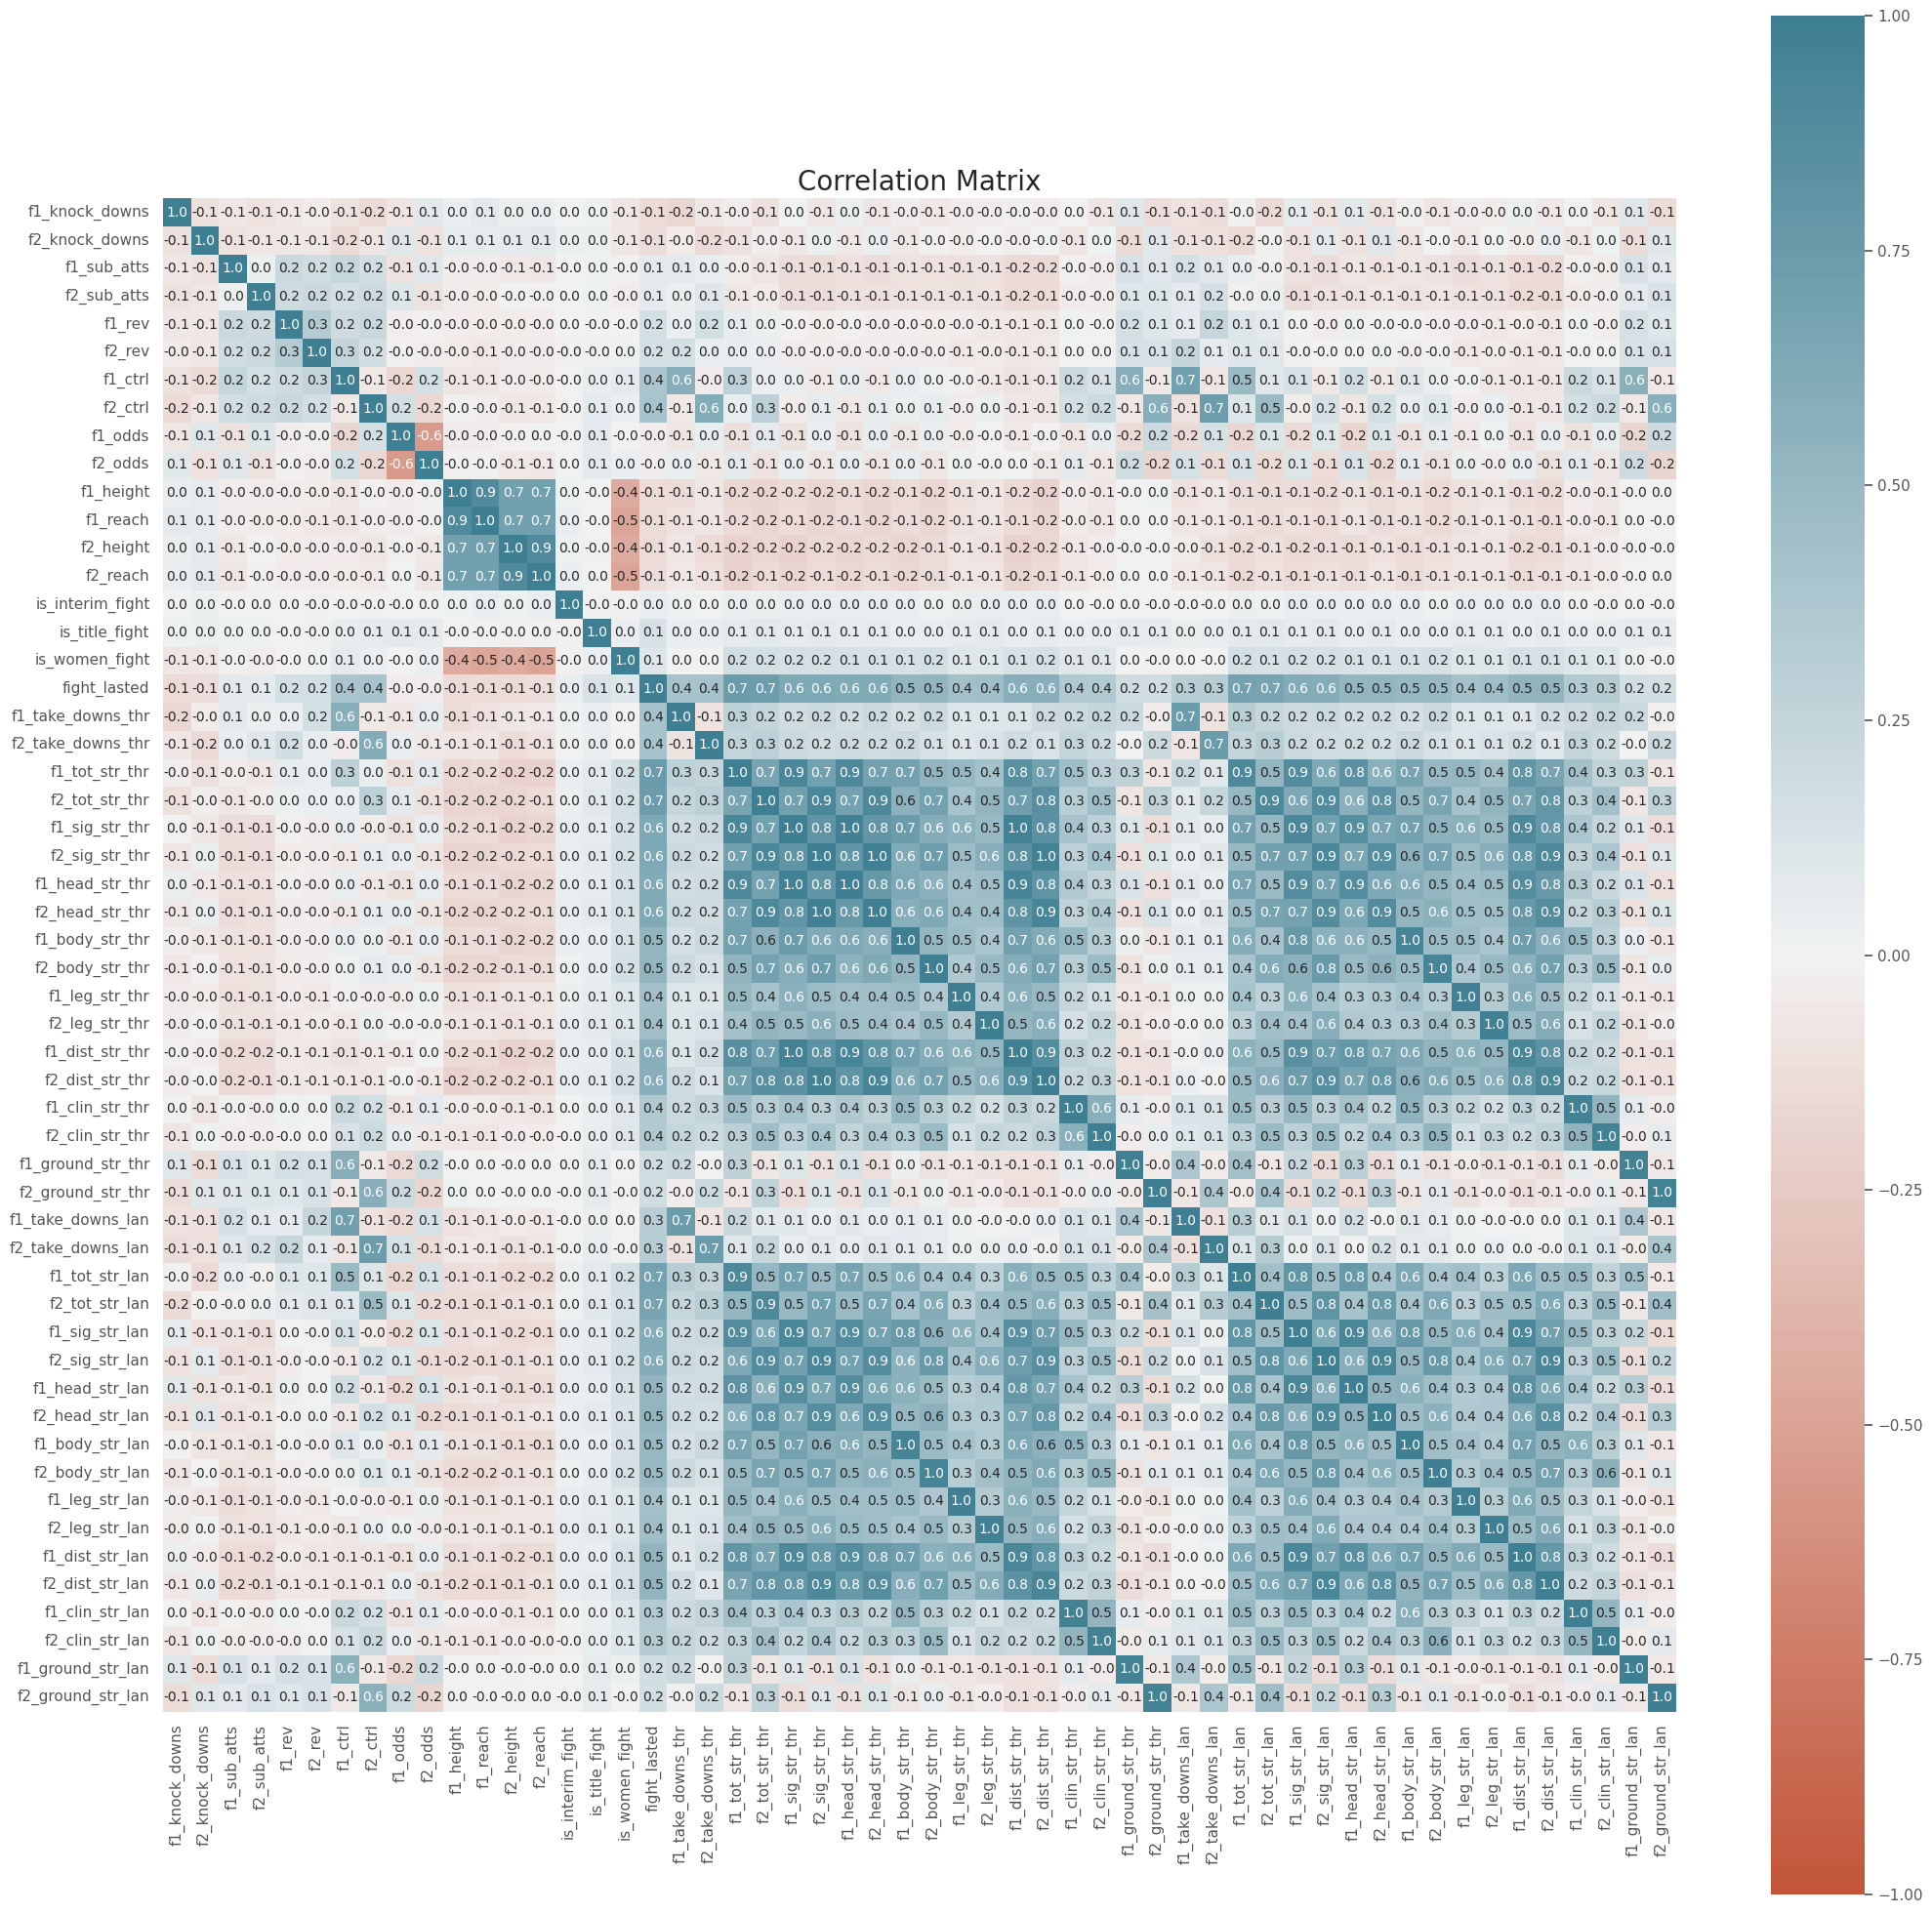

In [73]:
numerical_columns = df.select_dtypes(include=np.number).columns[1:].tolist()
plot_corr_matrix(df, numerical_columns)

### <div style="margin-left: 1em;">Correlated Features</div>
<div style="margin-left: 3em;"><font color='gray'>
   <strong><font color='#A9A9A9'>Positive</font></strong> 
      <li><u><font color='grey'>Height to Reach</u></li>
         <div style="margin-left: 2em;"><font color='gray'>The taller a fighter is the wider hir arm reach will be</font></div>
      <li><u><font color='grey'>Fight lasted in seconds to strikes landed/thrown</u></li>
         <div style="margin-left: 2em;"><font color='gray'>The longer a fight drags on the more strikes will be thrown</font></div>
      <li><u><font color='grey'>Total strikes to significant strikes</u></li>
         <div style="margin-left: 2em;"><font color='gray'>Significant strikes is just a portion of total ones</font></div>
      <li><u><font color='grey'>Strikes thrown and landed</u></li>
         <div style="margin-left: 2em;"><font color='gray'>Strikes landed make up a pat of thrown ones</font></div><br>
   <strong><font color='#A9A9A9'>Negative</font></strong> 
      <li><u><font color='grey'>Height/Reach to whether it's a women/men fight</u></li>
         <div style="margin-left: 2em;"><font color='gray'>The taller a fighter is the lesser probability is that its a fight between women</font></div>
      <li><u><font color='grey'>Odds of the fighters</u></li>
         <div style="margin-left: 2em;"><font color='gray'>The higher winning odds of a fighter the lesser ones of the other one</font></div>

These correlations wont matter for boosting models such as Catboost</font></div>

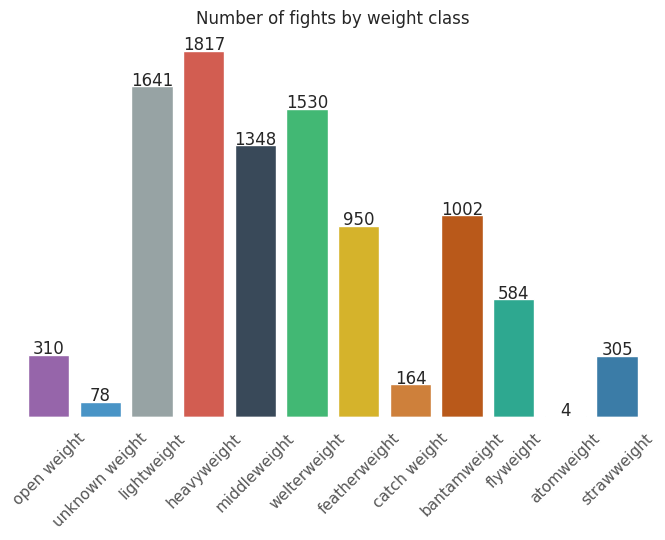

In [74]:
plot_countplot(
    events_df, 
    'weight_class', 
    "Number of fights by weight class"
)

<Figure size 800x500 with 0 Axes>

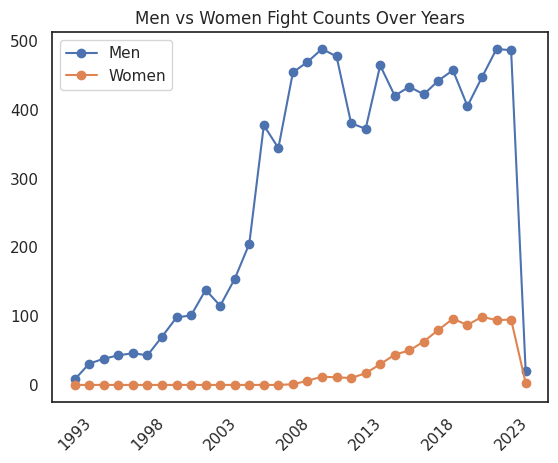

In [75]:
fight_counts = (
    df.groupby([df['event_date'].dt.year, 'is_women_fight'])
        .size()
        .unstack(fill_value=0)
)

plot_lineplot(
    df = fight_counts, 
    title = 'Men vs Women Fight Counts Over Years', 
    legend = ['Men', 'Women']
)

<div style="margin-left: 1em;"><font color='gray'>The women divition was introduced not that long ago hence the disproportion. The lines suddenly drop as we have data up to February 2024</font></div>

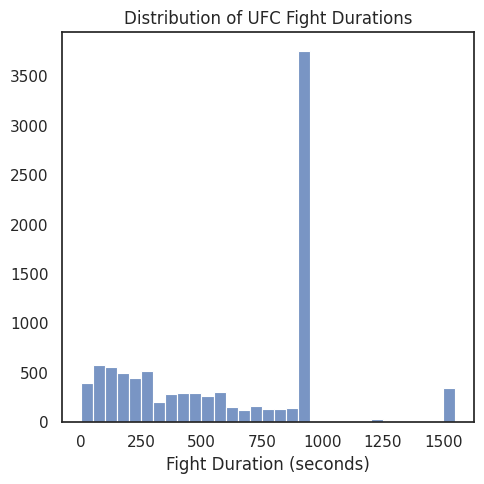

In [76]:
plot_hist(
    data=events_df, 
    x='fight_lasted', 
    bins=np.arange(0, 1600, 50), 
    xlabel = 'Fight Duration (seconds)',
    title = 'Distribution of UFC Fight Durations'
    )

<div style="margin-left: 1em;"><font color='gray'>As we can see most of the fights last all 5 rounds with some fights lasted around 1500 seconds. These are the old "Unlimited" fights. From the graph we can see that if probability of a fight to end in early rounds is higher and as the fights go on the probability decreases. It might have something to do with stamina depletion. </font></div>

In [77]:
event_country_counts = df['event_country'].value_counts()

fig = px.pie(
    names=event_country_counts.index,
    values=event_country_counts.values,
    title='UFC Events by Country',
    hole=0.5,
    width=700,
    height=500   
)

fig.update_traces(textposition='inside', textinfo='label')
fig.show()

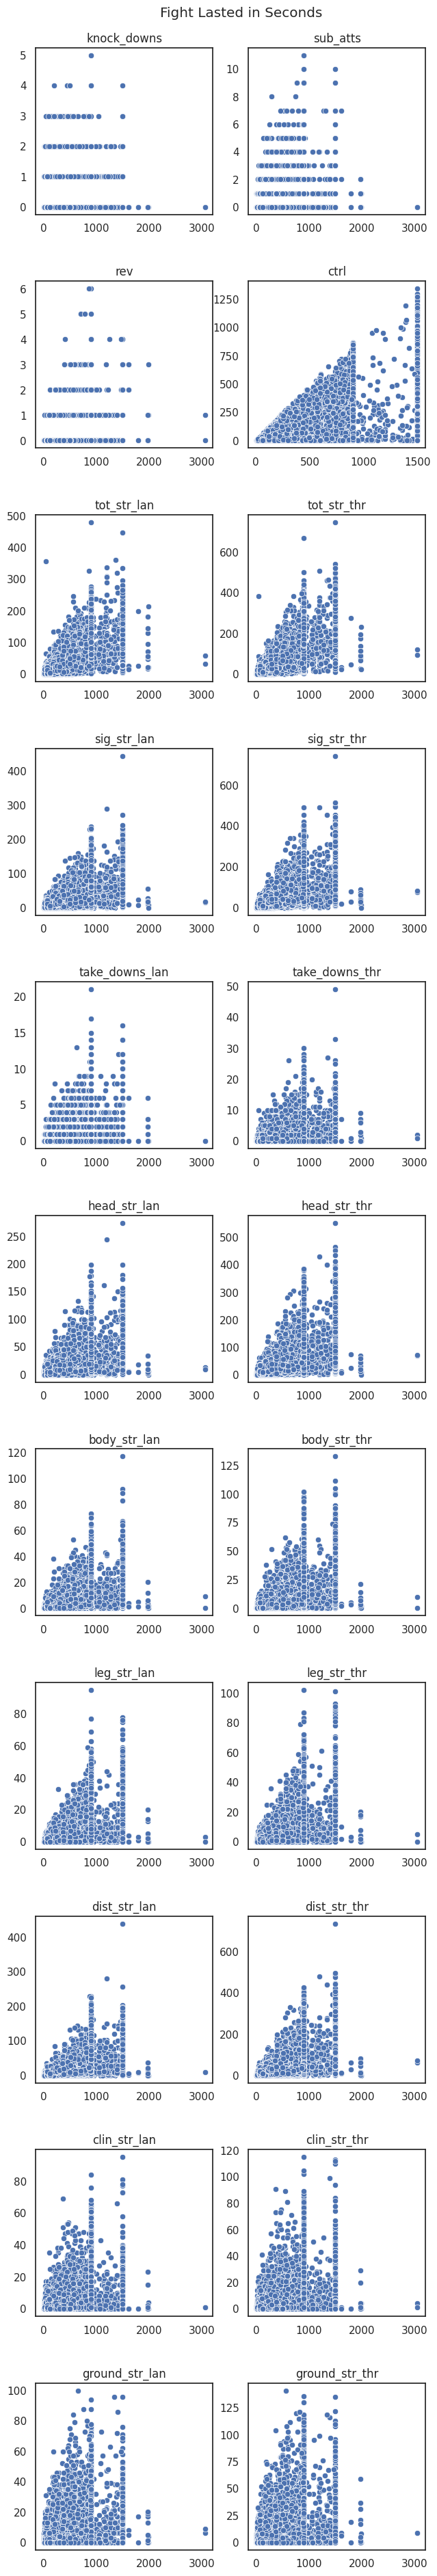

In [78]:
nrows=math.ceil(len(COLUMNS_FOR_SUBPLOTS)/2)

plot_scatterplots(
    df=fighters_df, 
    x = 'fight_lasted',
    columns=COLUMNS_FOR_SUBPLOTS, 
    title="Fight Lasted in Seconds", 
    nrows=nrows,
    ncols=2
    )

## 5. Feature Selection and Creation


In [79]:
# Creating age feature
fighters_df['age_at_event'] = (
    (fighters_df['event_date'] - fighters_df['dob']).dt.days / 365
)

# Creating wins, losses, draws, ncs and winning streaks
features_df = get_stats(fighters_df)
fighters_df = pd.concat([fighters_df, features_df], axis=1)

# Creating days_since_last_fight feature
fighters_df['days_since_last_fight'] = (
    fighters_df.groupby('name')['event_date'].diff().dt.days
)

fighters_df.tail()

,fight_id,event_date,fight_lasted,name,dob,odds,height,stance,reach,knock_downs,sub_atts,rev,ctrl,tot_str_lan,tot_str_thr,sig_str_lan,sig_str_thr,take_downs_lan,take_downs_thr,head_str_lan,head_str_thr,body_str_lan,body_str_thr,leg_str_lan,leg_str_thr,dist_str_lan,dist_str_thr,clin_str_lan,clin_str_thr,ground_str_lan,ground_str_thr,target,age_at_event,winning_streak,wins_over_carrier,losses_over_carrier,draws_over_carrier,ncs_over_carrier,days_since_last_fight
19461,9916,2024-01-20,861.0,Jasmine Jasudavicius,1989-03-01,1.27,67.0,Orthodox,68.0,1.0,3.0,0.0,685.0,326.0,398.0,93.0,120.0,2.0,5.0,84.0,109.0,6.0,8.0,3.0,3.0,23.0,34.0,2.0,3.0,68.0,83.0,W,34.912329,1,5,2,0,0,126.0
19462,9917,2024-01-20,900.0,Movsar Evloev,1994-02-11,1.54,67.0,Orthodox,72.0,0.0,0.0,0.0,211.0,72.0,141.0,51.0,118.0,5.0,17.0,35.0,101.0,12.0,13.0,4.0,4.0,45.0,110.0,5.0,7.0,1.0,1.0,W,29.958904,8,8,0,0,0,259.0
19463,9917,2024-01-20,900.0,Arnold Allen,1994-01-22,2.80,68.0,Southpaw,70.0,0.0,1.0,0.0,3.0,61.0,143.0,59.0,140.0,0.0,0.0,41.0,115.0,17.0,24.0,1.0,1.0,46.0,124.0,9.0,12.0,4.0,4.0,L,30.013699,0,10,2,0,0,280.0
19464,9918,2024-01-20,900.0,Ramon Taveras,1994-01-09,2.80,68.0,Southpaw,70.0,1.0,0.0,0.0,6.0,62.0,148.0,62.0,147.0,0.0,0.0,48.0,131.0,8.0,10.0,6.0,6.0,60.0,144.0,1.0,1.0,1.0,2.0,W,30.049315,2,2,1,0,0,102.0
19465,9918,2024-01-20,900.0,Serhiy Sidey,1996-07-04,1.56,71.0,Switch,72.0,0.0,0.0,0.0,24.0,81.0,229.0,79.0,226.0,0.0,4.0,51.0,181.0,20.0,36.0,8.0,9.0,73.0,218.0,6.0,8.0,0.0,0.0,L,27.564384,0,1,1,0,0,137.0


In [80]:
# Creating annual cumulative rolling features

year_in_weeks = 52

# Creating rolling mean features
rolling_mean_df = get_rolling_features(
    fighters_df, 
    COLUMNS_TO_GET_ROLLING_MEANS, 
    year_in_weeks, 
    'mean'
)
fighters_df = pd.concat([fighters_df, rolling_mean_df], axis=1)

# Creating rolling count features
rolling_count_cols = ['target']
rolling_count_df = get_rolling_features(
    fighters_df, 
    rolling_count_cols, 
    year_in_weeks, 
    'count'
)
fighters_df = pd.concat([fighters_df, rolling_count_df], axis=1)


fighters_df.rename(columns={
    'target_count_over_1_year':'num_of_fights_over_1_year'
    }, inplace=True)

fighters_df.drop(columns='target', inplace=True)
fighters_df.tail()

,fight_id,event_date,fight_lasted,name,dob,odds,height,stance,reach,knock_downs,sub_atts,rev,ctrl,tot_str_lan,tot_str_thr,sig_str_lan,sig_str_thr,take_downs_lan,take_downs_thr,head_str_lan,head_str_thr,body_str_lan,body_str_thr,leg_str_lan,leg_str_thr,dist_str_lan,dist_str_thr,clin_str_lan,clin_str_thr,ground_str_lan,ground_str_thr,age_at_event,winning_streak,wins_over_carrier,losses_over_carrier,draws_over_carrier,ncs_over_carrier,days_since_last_fight,fight_lasted_mean_over_1_year,knock_downs_mean_over_1_year,sub_atts_mean_over_1_year,rev_mean_over_1_year,ctrl_mean_over_1_year,tot_str_lan_mean_over_1_year,tot_str_thr_mean_over_1_year,sig_str_lan_mean_over_1_year,sig_str_thr_mean_over_1_year,take_downs_lan_mean_over_1_year,take_downs_thr_mean_over_1_year,head_str_lan_mean_over_1_year,head_str_thr_mean_over_1_year,body_str_lan_mean_over_1_year,body_str_thr_mean_over_1_year,leg_str_lan_mean_over_1_year,leg_str_thr_mean_over_1_year,dist_str_lan_mean_over_1_year,dist_str_thr_mean_over_1_year,clin_str_lan_mean_over_1_year,clin_str_thr_mean_over_1_year,ground_str_lan_mean_over_1_year,ground_str_thr_mean_over_1_year,num_of_fights_over_1_year
19461,9916,2024-01-20,861.0,Jasmine Jasudavicius,1989-03-01,1.27,67.0,Orthodox,68.0,1.0,3.0,0.0,685.0,326.0,398.0,93.0,120.0,2.0,5.0,84.0,109.0,6.0,8.0,3.0,3.0,23.0,34.0,2.0,3.0,68.0,83.0,34.912329,1,5,2,0,0,126.0,890.25,0.25,0.75,0.0,502.75,171.25,268.25,65.25,134.5,2.25,6.0,49.0,110.75,12.25,19.25,4.0,4.5,37.5,97.0,8.75,13.0,19.0,24.5,4
19462,9917,2024-01-20,900.0,Movsar Evloev,1994-02-11,1.54,67.0,Orthodox,72.0,0.0,0.0,0.0,211.0,72.0,141.0,51.0,118.0,5.0,17.0,35.0,101.0,12.0,13.0,4.0,4.0,45.0,110.0,5.0,7.0,1.0,1.0,29.958904,8,8,0,0,0,259.0,900.0,0.0,0.0,0.0,360.5,127.5,184.5,69.5,123.5,4.5,12.0,55.5,108.5,7.5,8.0,6.5,7.0,45.0,95.5,8.0,9.0,16.5,19.0,2
19463,9917,2024-01-20,900.0,Arnold Allen,1994-01-22,2.80,68.0,Southpaw,70.0,0.0,1.0,0.0,3.0,61.0,143.0,59.0,140.0,0.0,0.0,41.0,115.0,17.0,24.0,1.0,1.0,46.0,124.0,9.0,12.0,4.0,4.0,30.013699,0,10,2,0,0,280.0,1200.0,0.0,0.5,0.0,22.5,70.5,186.0,67.5,182.5,0.0,0.0,44.5,144.0,17.5,30.0,5.5,8.5,61.0,174.5,4.5,6.0,2.0,2.0,2
19464,9918,2024-01-20,900.0,Ramon Taveras,1994-01-09,2.80,68.0,Southpaw,70.0,1.0,0.0,0.0,6.0,62.0,148.0,62.0,147.0,0.0,0.0,48.0,131.0,8.0,10.0,6.0,6.0,60.0,144.0,1.0,1.0,1.0,2.0,30.049315,2,2,1,0,0,102.0,358.333333,0.666667,0.0,0.0,2.0,27.666667,61.333333,27.666667,61.0,0.0,0.0,21.666667,54.0,3.666667,4.666667,2.333333,2.333333,26.333333,59.333333,0.333333,0.333333,1.0,1.333333,3
19465,9918,2024-01-20,900.0,Serhiy Sidey,1996-07-04,1.56,71.0,Switch,72.0,0.0,0.0,0.0,24.0,81.0,229.0,79.0,226.0,0.0,4.0,51.0,181.0,20.0,36.0,8.0,9.0,73.0,218.0,6.0,8.0,0.0,0.0,27.564384,0,1,1,0,0,137.0,523.0,0.5,0.0,0.0,13.0,46.0,130.0,45.0,128.5,0.0,2.0,29.0,102.5,11.5,21.0,4.5,5.0,41.5,122.0,3.0,4.5,0.5,2.0,2


In [81]:
temp = fighters_df[fighters_df.name == 'Movsar Evloev']
                   
# Shifting values to prevent data leakage
for col in COLUMNS_TO_SHIFT:
    fighters_df[f"{col}_shift_1"] = (
        fighters_df.groupby(['name'])[f"{col}"].shift(1)
    )
    
fighters_df.drop(columns=COLUMNS_TO_SHIFT, inplace=True)
fighters_df.to_parquet('./processed_data/fighters_df.parquet')
fighters_df.tail()

,fight_id,event_date,name,dob,odds,height,stance,reach,age_at_event,winning_streak,days_since_last_fight,wins_over_carrier_shift_1,losses_over_carrier_shift_1,draws_over_carrier_shift_1,ncs_over_carrier_shift_1,num_of_fights_over_1_year_shift_1,fight_lasted_shift_1,fight_lasted_mean_over_1_year_shift_1,knock_downs_shift_1,knock_downs_mean_over_1_year_shift_1,sig_str_lan_shift_1,sig_str_lan_mean_over_1_year_shift_1,sig_str_thr_shift_1,sig_str_thr_mean_over_1_year_shift_1,tot_str_lan_shift_1,tot_str_lan_mean_over_1_year_shift_1,tot_str_thr_shift_1,tot_str_thr_mean_over_1_year_shift_1,take_downs_lan_shift_1,take_downs_lan_mean_over_1_year_shift_1,take_downs_thr_shift_1,take_downs_thr_mean_over_1_year_shift_1,sub_atts_shift_1,sub_atts_mean_over_1_year_shift_1,rev_shift_1,rev_mean_over_1_year_shift_1,ctrl_shift_1,ctrl_mean_over_1_year_shift_1,head_str_lan_shift_1,head_str_lan_mean_over_1_year_shift_1,head_str_thr_shift_1,head_str_thr_mean_over_1_year_shift_1,body_str_lan_shift_1,body_str_lan_mean_over_1_year_shift_1,body_str_thr_shift_1,body_str_thr_mean_over_1_year_shift_1,leg_str_lan_shift_1,leg_str_lan_mean_over_1_year_shift_1,leg_str_thr_shift_1,leg_str_thr_mean_over_1_year_shift_1,dist_str_lan_shift_1,dist_str_lan_mean_over_1_year_shift_1,dist_str_thr_shift_1,dist_str_thr_mean_over_1_year_shift_1,clin_str_lan_shift_1,clin_str_lan_mean_over_1_year_shift_1,clin_str_thr_shift_1,clin_str_thr_mean_over_1_year_shift_1,ground_str_lan_shift_1,ground_str_lan_mean_over_1_year_shift_1,ground_str_thr_shift_1,ground_str_thr_mean_over_1_year_shift_1
19461,9916,2024-01-20,Jasmine Jasudavicius,1989-03-01,1.27,67.0,Orthodox,68.0,34.912329,1,126.0,4.0,2.0,0.0,0.0,3,900.0,900.0,0.0,0.0,77.0,56.0,206.0,139.333333,95.0,119.666667,225.0,225.0,2.0,2.333333,10.0,6.333333,0.0,0.0,0.0,0.0,180.0,442.0,43.0,37.333333,148.0,111.333333,25.0,14.333333,47.0,23.0,9.0,4.333333,11.0,5.0,58.0,42.333333,176.0,118.0,19.0,11.0,30.0,16.333333,0.0,2.666667,0.0,5.0
19462,9917,2024-01-20,Movsar Evloev,1994-02-11,1.54,67.0,Orthodox,72.0,29.958904,8,259.0,7.0,0.0,0.0,0.0,2,900.0,900.0,0.0,0.0,88.0,78.0,129.0,129.0,183.0,163.5,228.0,220.5,4.0,6.5,7.0,11.5,0.0,0.0,0.0,0.0,510.0,458.5,76.0,63.0,116.0,112.5,3.0,7.5,3.0,8.5,9.0,7.5,10.0,8.0,45.0,48.0,81.0,95.5,11.0,6.5,11.0,6.5,32.0,23.5,37.0,27.0
19463,9917,2024-01-20,Arnold Allen,1994-01-22,2.80,68.0,Southpaw,70.0,30.013699,0,280.0,10.0,1.0,0.0,0.0,2,1500.0,904.0,0.0,0.0,76.0,52.0,225.0,146.0,80.0,54.0,229.0,148.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,32.5,48.0,34.5,173.0,114.0,18.0,10.0,36.0,20.5,10.0,7.5,16.0,11.5,76.0,51.5,225.0,143.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,2.5
19464,9918,2024-01-20,Ramon Taveras,1994-01-09,2.80,68.0,Southpaw,70.0,30.049315,2,102.0,1.0,1.0,0.0,0.0,2,29.0,87.5,1.0,0.5,10.0,10.5,17.0,18.0,10.0,10.5,17.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.5,13.0,15.5,3.0,1.5,4.0,2.0,0.0,0.5,0.0,0.5,8.0,9.5,15.0,17.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,1.0
19465,9918,2024-01-20,Serhiy Sidey,1996-07-04,1.56,71.0,Switch,72.0,27.564384,0,137.0,1.0,0.0,0.0,0.0,1,146.0,146.0,1.0,1.0,11.0,11.0,31.0,31.0,11.0,11.0,31.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,7.0,7.0,24.0,24.0,3.0,3.0,6.0,6.0,1.0,1.0,1.0,1.0,10.0,10.0,26.0,26.0,0.0,0.0,1.0,1.0,1.0,1.0,4.0,4.0


In [82]:
# Remerging dataframes for model training
baseline_df = events_df

fighters = [1,2]

for num in fighters:
    
    baseline_df = pd.merge(
        baseline_df, 
        fighters_df.rename(add_fighter_prefix(num, fighters_df), axis=1),
        how='left',
        on=['fight_id', 'event_date', f'f{num}_name']
    )
baseline_df.to_parquet('./processed_data/baseline_df.parquet')
baseline_df.head()

,fight_id,event_date,event_country,is_interim_fight,is_title_fight,is_women_fight,weight_class,fight_lasted,method,referee,details,f1_name,f2_name,target,f1_dob,f1_odds,f1_height,f1_stance,f1_reach,f1_age_at_event,f1_winning_streak,f1_days_since_last_fight,f1_wins_over_carrier_shift_1,f1_losses_over_carrier_shift_1,f1_draws_over_carrier_shift_1,f1_ncs_over_carrier_shift_1,f1_num_of_fights_over_1_year_shift_1,f1_fight_lasted_shift_1,f1_fight_lasted_mean_over_1_year_shift_1,f1_knock_downs_shift_1,f1_knock_downs_mean_over_1_year_shift_1,f1_sig_str_lan_shift_1,f1_sig_str_lan_mean_over_1_year_shift_1,f1_sig_str_thr_shift_1,f1_sig_str_thr_mean_over_1_year_shift_1,f1_tot_str_lan_shift_1,f1_tot_str_lan_mean_over_1_year_shift_1,f1_tot_str_thr_shift_1,f1_tot_str_thr_mean_over_1_year_shift_1,f1_take_downs_lan_shift_1,f1_take_downs_lan_mean_over_1_year_shift_1,f1_take_downs_thr_shift_1,f1_take_downs_thr_mean_over_1_year_shift_1,f1_sub_atts_shift_1,f1_sub_atts_mean_over_1_year_shift_1,f1_rev_shift_1,f1_rev_mean_over_1_year_shift_1,f1_ctrl_shift_1,f1_ctrl_mean_over_1_year_shift_1,f1_head_str_lan_shift_1,f1_head_str_lan_mean_over_1_year_shift_1,f1_head_str_thr_shift_1,f1_head_str_thr_mean_over_1_year_shift_1,f1_body_str_lan_shift_1,f1_body_str_lan_mean_over_1_year_shift_1,f1_body_str_thr_shift_1,f1_body_str_thr_mean_over_1_year_shift_1,f1_leg_str_lan_shift_1,f1_leg_str_lan_mean_over_1_year_shift_1,f1_leg_str_thr_shift_1,f1_leg_str_thr_mean_over_1_year_shift_1,f1_dist_str_lan_shift_1,f1_dist_str_lan_mean_over_1_year_shift_1,f1_dist_str_thr_shift_1,f1_dist_str_thr_mean_over_1_year_shift_1,f1_clin_str_lan_shift_1,f1_clin_str_lan_mean_over_1_year_shift_1,f1_clin_str_thr_shift_1,f1_clin_str_thr_mean_over_1_year_shift_1,f1_ground_str_lan_shift_1,f1_ground_str_lan_mean_over_1_year_shift_1,f1_ground_str_thr_shift_1,f1_ground_str_thr_mean_over_1_year_shift_1,f2_dob,f2_odds,f2_height,f2_stance,f2_reach,f2_age_at_event,f2_winning_streak,f2_days_since_last_fight,f2_wins_over_carrier_shift_1,f2_losses_over_carrier_shift_1,f2_draws_over_carrier_shift_1,f2_ncs_over_carrier_shift_1,f2_num_of_fights_over_1_year_shift_1,f2_fight_lasted_shift_1,f2_fight_lasted_mean_over_1_year_shift_1,f2_knock_downs_shift_1,f2_knock_downs_mean_over_1_year_shift_1,f2_sig_str_lan_shift_1,f2_sig_str_lan_mean_over_1_year_shift_1,f2_sig_str_thr_shift_1,f2_sig_str_thr_mean_over_1_year_shift_1,f2_tot_str_lan_shift_1,f2_tot_str_lan_mean_over_1_year_shift_1,f2_tot_str_thr_shift_1,f2_tot_str_thr_mean_over_1_year_shift_1,f2_take_downs_lan_shift_1,f2_take_downs_lan_mean_over_1_year_shift_1,f2_take_downs_thr_shift_1,f2_take_downs_thr_mean_over_1_year_shift_1,f2_sub_atts_shift_1,f2_sub_atts_mean_over_1_year_shift_1,f2_rev_shift_1,f2_rev_mean_over_1_year_shift_1,f2_ctrl_shift_1,f2_ctrl_mean_over_1_year_shift_1,f2_head_str_lan_shift_1,f2_head_str_lan_mean_over_1_year_shift_1,f2_head_str_thr_shift_1,f2_head_str_thr_mean_over_1_year_shift_1,f2_body_str_lan_shift_1,f2_body_str_lan_mean_over_1_year_shift_1,f2_body_str_thr_shift_1,f2_body_str_thr_mean_over_1_year_shift_1,f2_leg_str_lan_shift_1,f2_leg_str_lan_mean_over_1_year_shift_1,f2_leg_str_thr_shift_1,f2_leg_str_thr_mean_over_1_year_shift_1,f2_dist_str_lan_shift_1,f2_dist_str_lan_mean_over_1_year_shift_1,f2_dist_str_thr_shift_1,f2_dist_str_thr_mean_over_1_year_shift_1,f2_clin_str_lan_shift_1,f2_clin_str_lan_mean_over_1_year_shift_1,f2_clin_str_thr_shift_1,f2_clin_str_thr_mean_over_1_year_shift_1,f2_ground_str_lan_shift_1,f2_ground_str_lan_mean_over_1_year_shift_1,f2_ground_str_thr_shift_1,f2_ground_str_thr_mean_over_1_year_shift_1
0,0,1993-11-12,USA,0,0,0,open weight,59.0,KO/TKO,Joao Alberto Barreto,to \n Corner Stoppage,Gerard Gordeau,Kevin Rosier,F1,1959-03-30,NaN,77.0,Orthodox,NaN,34.646575,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,76.0,Orthodox,NaN,NaN,0,NaN,NaN,NaN,

## 6. Model Training

In [88]:
baseline_df = pd.read_parquet('./processed_data/baseline_df.parquet')

In [89]:
split_date = baseline_df['event_date'].max() - pd.Timedelta(days=120)
split_date

Timestamp('2023-09-22 00:00:00')

In [163]:
np.random.seed(42)

pd.DataFrame.iteritems = pd.DataFrame.items


df_train = baseline_df[baseline_df['event_date'] <= split_date]
df_test = baseline_df[baseline_df['event_date'] > split_date]

drop_features = (
    ['fight_id', 'fight_lasted','event_date', 'method',
    'referee', 'details', 'f1_name', 'f2_name', 'target', 'f1_dob', 'f2_dob'] 
)

features = list(
    set(baseline_df.columns) - 
    set(drop_features) 
) 

cat_features = ['event_country', 'weight_class', 'f1_stance', 'f2_stance']

tscv = TimeSeriesSplit(n_splits=5)  

precision_scores = []

for train_index, val_index in tscv.split(df_train):
    X_split_train = df_train.loc[train_index,features]
    X_split_val = df_train.loc[val_index, features]
    y_split_train = df_train.loc[train_index, 'target']
    y_split_val = df_train.loc[val_index, 'target']

    CBC = CatBoostClassifier(
        n_estimators=2000,
        loss_function='MultiClass',
        od_type = "Iter",
        od_wait = 50,
        verbose=100,
    )
    CBC.fit(
        X_split_train, 
        y_split_train, 
        eval_set=(X_split_val, y_split_val),
        cat_features=cat_features
    )
    y_pred = CBC.predict(X_split_val)
    precision = precision_score(y_split_val, y_pred, average='micro')
    precision_scores.append(precision)

Learning rate set to 0.083639
0:	learn: 0.6169269	test: 0.6189481	best: 0.6189481 (0)	total: 52.8ms	remaining: 1m 45s
100:	learn: 0.0046349	test: 0.0073562	best: 0.0073562 (100)	total: 849ms	remaining: 16s
200:	learn: 0.0017776	test: 0.0031557	best: 0.0031557 (200)	total: 1.63s	remaining: 14.5s
300:	learn: 0.0011100	test: 0.0020559	best: 0.0020559 (300)	total: 2.41s	remaining: 13.6s
400:	learn: 0.0008134	test: 0.0015375	best: 0.0015375 (400)	total: 3.17s	remaining: 12.7s
500:	learn: 0.0006442	test: 0.0012304	best: 0.0012304 (500)	total: 3.98s	remaining: 11.9s
600:	learn: 0.0005357	test: 0.0010299	best: 0.0010299 (600)	total: 4.8s	remaining: 11.2s


700:	learn: 0.0004589	test: 0.0008861	best: 0.0008861 (700)	total: 5.64s	remaining: 10.5s
800:	learn: 0.0004027	test: 0.0007804	best: 0.0007804 (800)	total: 6.45s	remaining: 9.66s
900:	learn: 0.0003589	test: 0.0006986	best: 0.0006986 (900)	total: 7.26s	remaining: 8.86s
1000:	learn: 0.0003239	test: 0.0006330	best: 0.0006330 (1000)	total: 8.07s	remaining: 8.05s
1100:	learn: 0.0002948	test: 0.0005782	best: 0.0005782 (1100)	total: 8.95s	remaining: 7.3s
1200:	learn: 0.0002702	test: 0.0005319	best: 0.0005319 (1200)	total: 9.8s	remaining: 6.52s
1300:	learn: 0.0002496	test: 0.0004930	best: 0.0004930 (1300)	total: 10.6s	remaining: 5.69s
1400:	learn: 0.0002321	test: 0.0004598	best: 0.0004598 (1400)	total: 11.4s	remaining: 4.87s
1500:	learn: 0.0002168	test: 0.0004310	best: 0.0004310 (1500)	total: 12.2s	remaining: 4.05s
1600:	learn: 0.0002034	test: 0.0004057	best: 0.0004057 (1600)	total: 12.9s	remaining: 3.23s
1700:	learn: 0.0001911	test: 0.0003822	best: 0.0003822 (1700)	total: 13.8s	remaining: 2.

In [164]:
np.mean(precision_scores)

1.0

In [118]:
CBC = CatBoostClassifier(
        n_estimators=500,
        loss_function='MultiClass',
        od_type = "Iter",
        od_wait = 50,
        verbose=100
    )
CBC.fit(
    df_train[features], 
    df_train['target'], 
    eval_set=(X_split_val, y_split_val),
    cat_features=cat_features
)
y_pred = CBC.predict(df_test[features])
precision = precision_score(df_test['target'], y_pred, average='micro')
precision

Learning rate set to 0.14727
0:	learn: 1.0068175	test: 1.0094302	best: 1.0094302 (0)	total: 26.6ms	remaining: 13.3s
100:	learn: 0.0171164	test: 0.0156054	best: 0.0156054 (100)	total: 3.04s	remaining: 12s


200:	learn: 0.0108103	test: 0.0094284	best: 0.0094284 (200)	total: 6.13s	remaining: 9.11s
300:	learn: 0.0073235	test: 0.0063606	best: 0.0063606 (300)	total: 9.15s	remaining: 6.05s
400:	learn: 0.0052726	test: 0.0045341	best: 0.0045341 (400)	total: 12.2s	remaining: 3.02s
499:	learn: 0.0042051	test: 0.0037057	best: 0.0037057 (499)	total: 15.2s	remaining: 0us

bestTest = 0.003705736436
bestIteration = 499



1.0

In [119]:
print(classification_report(df_test['target'], y_pred))

              precision    recall  f1-score   support

        Draw       1.00      1.00      1.00         2
          F1       1.00      1.00      1.00        75
          F2       1.00      1.00      1.00        74
          NC       1.00      1.00      1.00         4

    accuracy                           1.00       155
   macro avg       1.00      1.00      1.00       155
weighted avg       1.00      1.00      1.00       155



In [120]:
pd.DataFrame(
    np.vstack([CBC.feature_names_, CBC.feature_importances_]).T, 
    columns = ['features', 'score']
    )\
        .astype({'score': float})\
        .sort_values('score', ascending=False)\
        .head(20)

,features,score
38,f2_winning_streak,32.752239
80,f1_winning_streak,14.447314
110,f1_ncs_over_carrier_shift_1,5.564236
104,f1_draws_over_carrier_shift_1,4.793076
27,f2_ncs_over_carrier_shift_1,3.707332
86,f2_draws_over_carrier_shift_1,2.237754
59,f1_height,1.248757
21,f1_age_at_event_shift_1,1.186187
108,f2_wins_over_carrier_shift_1,1.141487
77,f1_days_since_last_fight,1.131940


In [ ]:
def objective(trial):

    params = {
        "learning_rate": 
            trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "objective": 
            trial.suggest_categorical(
                "objective", ["MultiClass", "MultiClassOneVsAll"]
                ),
        "colsample_bylevel": 
            trial.suggest_float("colsample_bylevel", 0.01, 0.1, log=True),
        "depth": 
            trial.suggest_int("depth", 1, 12),
        "l2_leaf_reg": 
            trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        "random_strength": 
            trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        "boosting_type": 
            trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": 
            trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
            ),
    }

    if params["bootstrap_type"] == "Bayesian":
        params["bagging_temperature"] = (
            trial.suggest_float("bagging_temperature", 0, 10)
        )
    elif params["bootstrap_type"] == "Bernoulli":
        params["subsample"] = (
            trial.suggest_float("subsample", 0.1, 1, log=True)
        )
        
    tscv = TimeSeriesSplit(n_splits=5)  

    precision_scores = []

    for train_index, val_index in tscv.split(df_train):
        train_data = df_train.iloc[train_index]
        val_data = df_train.iloc[val_index]

        CBC = CatBoostClassifier(
            **params,
            n_estimators=2000,
            loss_function='MultiClass',
            od_type = "Iter",
            od_wait = 50,
            verbose=False
        )
        CBC.fit(
            train_data[features], 
            train_data['target'], 
            cat_features=cat_features
        )
        y_pred = CBC.predict(val_data[features])
        precision = precision_score(val_data['target'], y_pred, average='micro')
        precision_scores.append(precision)

    return np.mean(precision_scores)

optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = TPESampler(seed=1)

study = optuna.create_study(direction="maximize", sampler=sampler)

In [ ]:
study.optimize(objective, n_trials=100)

In [ ]:
study_df = study.trials_dataframe()
study_df.to_parquet("./CBC_study.parquet")
with open("best_params.pkl", "wb") as f:
    pickle.dump(study.best_params, f)

In [ ]:
print("Best hyperparameters:", study.best_params)

Best hyperparameters: {'learning_rate': 0.021500331023939428, 'objective': 'MultiClass', 'colsample_bylevel': 0.0949480886778806, 'depth': 7, 'l2_leaf_reg': 10.59298622792364, 'random_strength': 0.38754349873601873, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS'}


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(
    study, 
    params=[
        "learning_rate",
        "objective",
        "colsample_bylevel",
        "depth",
        "random_strength",
        "l2_leaf_reg",
        "boosting_type",
        "bootstrap_type",
        "bagging_temperature",
        "subsample"
    ]
)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
with open("best_params.pkl", "rb") as f:
    best_params = pickle.load(f)

tscv = TimeSeriesSplit(n_splits=5)  

precision_scores = []

for train_index, val_index in tscv.split(df_train):
    X_split_train = df_train.loc[train_index,features]
    X_split_val = df_train.loc[val_index, features]
    y_split_train = df_train.loc[train_index, 'target']
    y_split_val = df_train.loc[val_index, 'target']

    CBC = CatBoostClassifier(
        **best_params,
        n_estimators=2000,
        loss_function='MultiClass',
        od_type = "Iter",
        od_wait = 50,
        verbose=100
    )
    CBC.fit(
        X_split_train, 
        y_split_train, 
        eval_set=(X_split_val, y_split_val),
        cat_features=cat_features
    )
    y_pred = CBC.predict(X_split_val)
    precision = precision_score(y_split_val, y_pred, average='micro')
    precision_scores.append(precision)

0:	learn: 1.3712313	test: 1.3734042	best: 1.3734042 (0)	total: 4.88ms	remaining: 9.75s
100:	learn: 0.7142522	test: 0.7873258	best: 0.7873258 (100)	total: 686ms	remaining: 12.9s
200:	learn: 0.5783672	test: 0.6694831	best: 0.6694831 (200)	total: 1.36s	remaining: 12.2s
300:	learn: 0.5158316	test: 0.6204524	best: 0.6204524 (300)	total: 2.09s	remaining: 11.8s
400:	learn: 0.4746786	test: 0.5961117	best: 0.5961117 (400)	total: 2.88s	remaining: 11.5s
500:	learn: 0.4449497	test: 0.5842289	best: 0.5842249 (498)	total: 3.61s	remaining: 10.8s
600:	learn: 0.4210695	test: 0.5771011	best: 0.5771011 (600)	total: 4.29s	remaining: 9.99s
700:	learn: 0.4031885	test: 0.5717039	best: 0.5717039 (700)	total: 4.99s	remaining: 9.25s
800:	learn: 0.3855969	test: 0.5679603	best: 0.5679603 (800)	total: 5.69s	remaining: 8.52s
900:	learn: 0.3703763	test: 0.5647320	best: 0.5647320 (900)	total: 6.37s	remaining: 7.77s
1000:	learn: 0.3577413	test: 0.5633553	best: 0.5632845 (995)	total: 7.1s	remaining: 7.08s
1100:	learn: 

0.7258758451137062

In [ ]:
np.mean(precision_scores)

0.7258758451137062

In [168]:
CBC = CatBoostClassifier(
        # **best_params,
        n_estimators=2000,
        loss_function='MultiClass',
        od_type = "Iter",
        od_wait = 50,
        verbose=100
    )
CBC.fit(
    df_train[features], 
    df_train['target'], 
    eval_set=(X_split_val, y_split_val),
    cat_features=cat_features
)
y_pred = CBC.predict(df_test[features])
precision = precision_score(df_test['target'], y_pred, average='micro')
precision

Learning rate set to 0.086689
0:	learn: 0.6108609	test: 0.6109869	best: 0.6109869 (0)	total: 12.6ms	remaining: 25.3s
100:	learn: 0.0008853	test: 0.0012858	best: 0.0012858 (100)	total: 1.17s	remaining: 22s


200:	learn: 0.0002610	test: 0.0005102	best: 0.0005102 (200)	total: 2.42s	remaining: 21.7s
300:	learn: 0.0001664	test: 0.0003458	best: 0.0003458 (300)	total: 3.68s	remaining: 20.8s
400:	learn: 0.0001248	test: 0.0002664	best: 0.0002664 (400)	total: 4.98s	remaining: 19.9s
500:	learn: 0.0001004	test: 0.0002176	best: 0.0002176 (500)	total: 6.24s	remaining: 18.7s
600:	learn: 0.0000840	test: 0.0001843	best: 0.0001843 (600)	total: 7.49s	remaining: 17.4s
700:	learn: 0.0000720	test: 0.0001592	best: 0.0001592 (700)	total: 8.69s	remaining: 16.1s
800:	learn: 0.0000630	test: 0.0001401	best: 0.0001401 (800)	total: 9.99s	remaining: 15s
900:	learn: 0.0000556	test: 0.0001244	best: 0.0001244 (900)	total: 11.3s	remaining: 13.8s
1000:	learn: 0.0000498	test: 0.0001119	best: 0.0001119 (1000)	total: 12.6s	remaining: 12.6s
1100:	learn: 0.0000447	test: 0.0001007	best: 0.0001007 (1100)	total: 13.9s	remaining: 11.4s
1200:	learn: 0.0000402	test: 0.0000908	best: 0.0000908 (1200)	total: 15.2s	remaining: 10.1s
1300:	

1.0

In [169]:
importances = permutation_importance(
    CBC, 
    df_train[features], 
    df_train['target'], 
    scoring='precision_micro', 
    n_repeats=10
)

feature_importances = pd.DataFrame(columns=['features', 'importance'])

for i, feat in enumerate(features):
    feature_importances.at[i, 'features'] = feat
    feature_importances.at[i, 'importance'] = importances['importances_mean'][i]

feature_importances.sort_values(by='importance', ascending=False).tail()

# Precision (average='micro')
# Baseline - 0.5172413793103449
# Initial oputna search - 0.7548387096774194
# Secondary oputna search - 0.7612903225806451
# 3rd oputna search - 0.6129032258064516
# 4th oputna search - 0.7612903225806451

,features,importance
36,f1_sig_str_thr_mean_over_1_year_shift_1,0.0
35,f2_ctrl_mean_over_1_year_shift_1,0.0
34,f2_leg_str_thr_mean_over_1_year_shift_1,0.0
33,f1_head_str_lan_mean_over_1_year_shift_1,0.0
120,f1_sig_str_lan_mean_over_1_year_shift_1,0.0


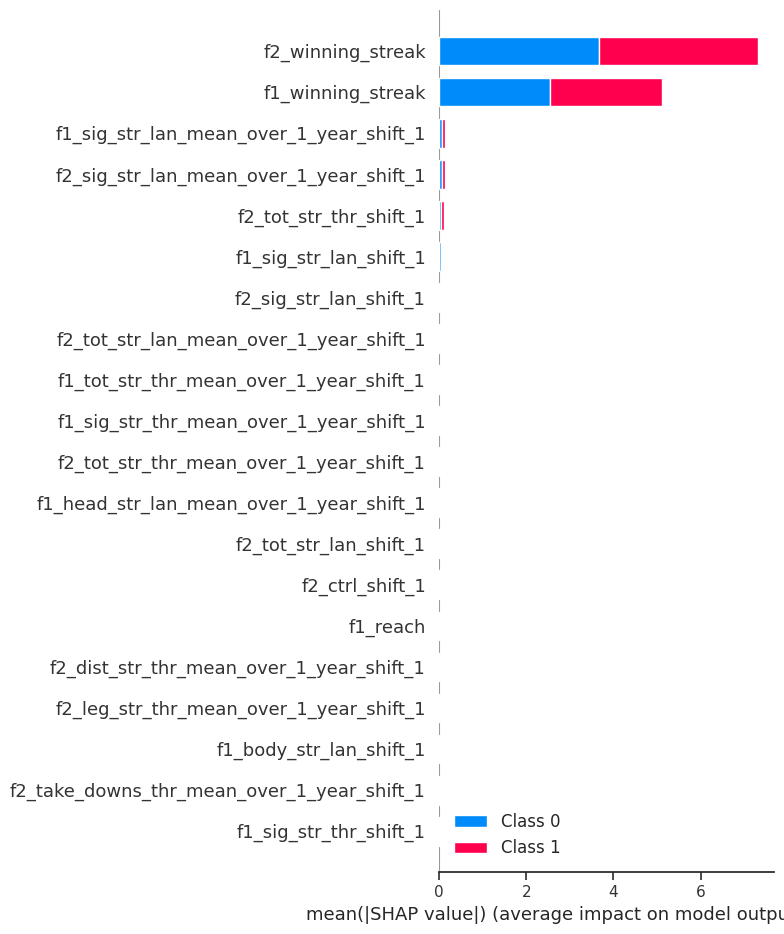

In [170]:
shap_values = shap.Explainer(CBC).shap_values(df_train[features])
shap.summary_plot(
    shap_values, 
    df_train[features],
    plot_type="bar",  
    max_display=20
)

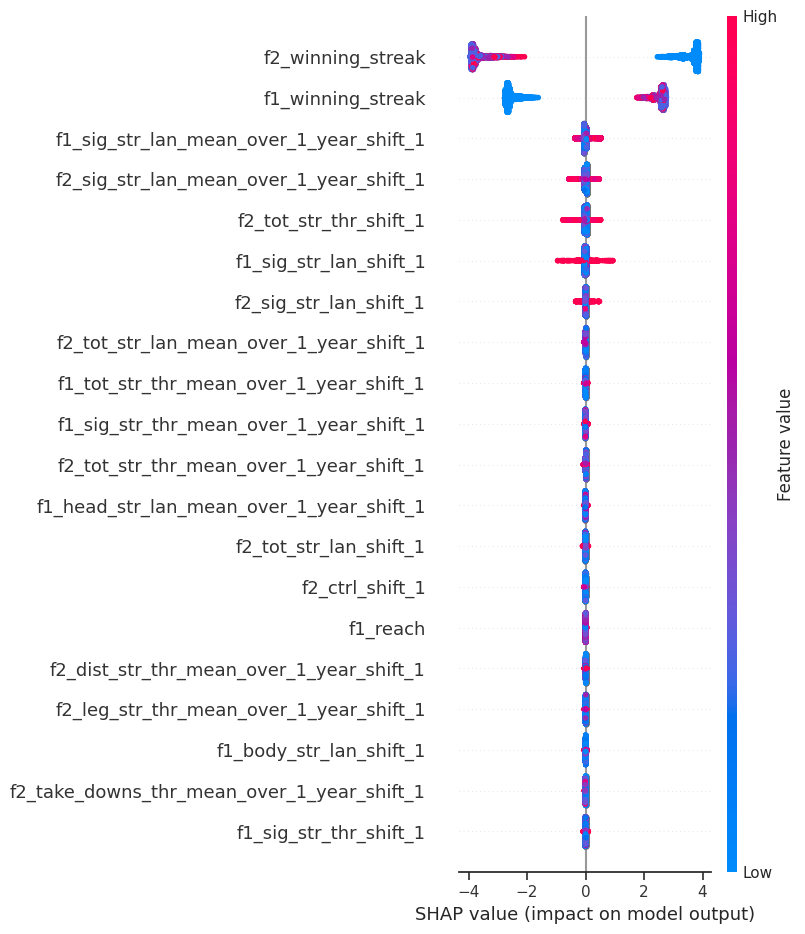

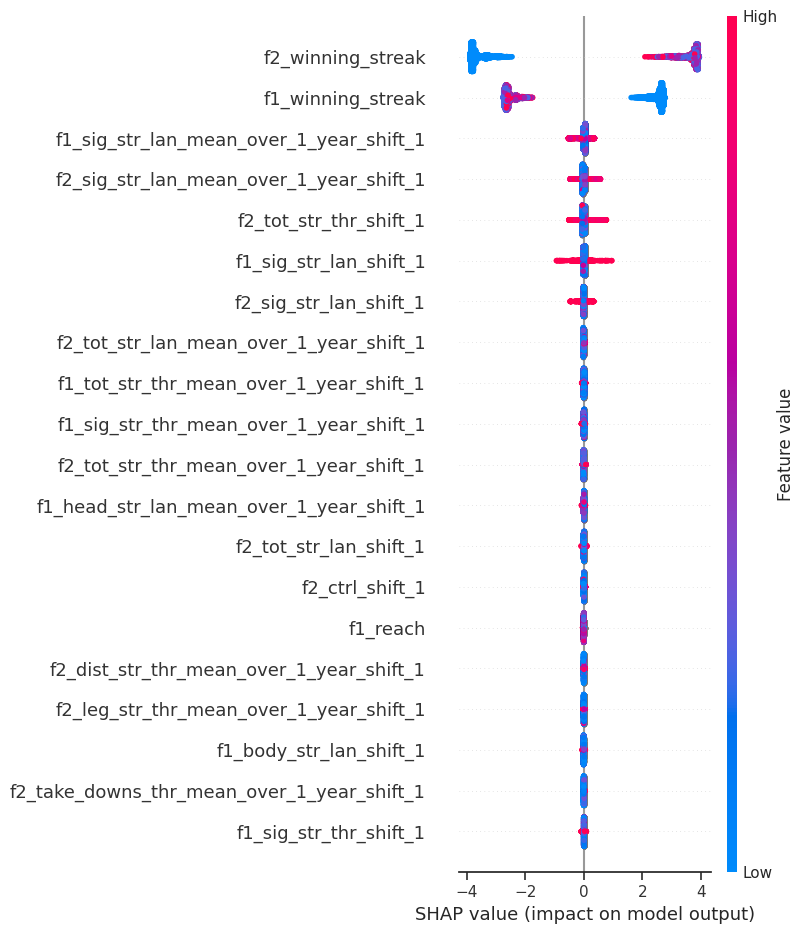

IndexError: list index out of range

In [171]:
for i in range(4): 
    shap.summary_plot(
        shap_values[i],
        df_train[features],
        plot_type="dot"
    )